In [1]:
#-*- encoding: utf-8 -*-
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from torch.optim.optimizer import Optimizer
from torch.optim import Adam,lr_scheduler,AdamW
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 

import pandas as pd
import numpy as np
import sys, gc, os, glob

# 학과 DGX CORE GPU 5인 경우 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
train_files = sorted(glob.glob('./train/*.npy'))
test_files = sorted(glob.glob('./test/*.npy'))

In [3]:
train_df = pd.DataFrame(train_files, columns = ['id'])
test_df = pd.DataFrame(test_files, columns = ['id'])

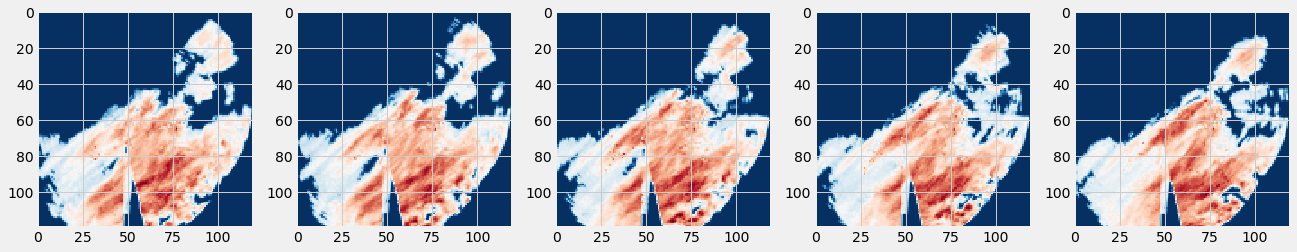

In [4]:
import matplotlib.pylab as plt

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[56]).flatten().reshape(120, 120, 5)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Train Dataset의 1, 2, 3, 4, 5 채널 모두 사용 
# 1->2, 2->3, 3->4, 4->5 를 학습 
class CloudTrainDataset(Dataset):
    """ Cloud Dataset """ 
    def __init__(self, data, type_):
        self.data = data
        self.type_ = type_
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        transform = transforms.Compose([
                transforms.ToTensor()
                ])
        image = np.load(self.data.loc[idx, 'id'])
        
        if self.type_ == 0: 
            target = image[:, :, 1]
            image = image[:, :, 0]
        elif self.type_ == 1: 
            target = image[:, :, 2]
            image = image[:, :, 1]        
        elif self.type_ == 2: 
            target = image[:, :, 3]
            image = image[:, :, 2]
        else : 
            target = image[:, :, 4]
            image = image[:, :, 3]
            
        return transform(image), transform(target) 

In [6]:
# Test Dataset의 1, 2, 3, 4 채널 사용 
# 1->2, 2->3, 3->4 예측하는 구조를 validation으로 활용
class CloudValidDataset(Dataset):
    """ Cloud Dataset """ 
    def __init__(self, data, type_):
        self.data = data
        self.type_ = type_
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        transform = transforms.Compose([
                transforms.ToTensor()
                ])
        image = np.load(self.data.loc[idx, 'id'])
        
        if self.type_ == 0: 
            target = image[:, :, 1]
            image = image[:, :, 0]
        elif self.type_ == 1: 
            target = image[:, :, 2]
            image = image[:, :, 1]        
        else: 
            target = image[:, :, 3]
            image = image[:, :, 2]

        return transform(image), transform(target) 

In [7]:
class CloudTestDataset(Dataset):
    """ Cloud Dataset """ 
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        transform = transforms.Compose([
                transforms.ToTensor()
                ])
        image = np.load(self.data.loc[idx, 'id'])
        return transform(image[:, :, 3])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

In [9]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            return cbr

        # Contracting path 
        # padding을 넣어서 output size가 바뀌지 않도록 설정했음 
        self.pad = nn.ZeroPad2d(4) 
        self.enc1_1 = CBR2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc1_2 = CBR2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)     
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc2_2 = CBR2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
 
        self.enc3_1 = CBR2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc3_2 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2)    

        self.enc4_1 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc4_2 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2)    

        self.enc5_1 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)

        # Expansive path 
        self.dec5_1 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.unpool4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        ## Encoder와 Decoder 파트의 인덱스를 동일하게 하기 위해서, 순서를 거꾸로 매겨줌 
        ### self.enc4_2의 output channel -> input channel / input channel -> output channel으로 매겨짐 
        ### 256인 이유는 self.enc4_2의 output channel + self.unpool4의 output channel 
        self.dec4_2 = CBR2d(in_channels=256, out_channels=128) 
        self.dec4_1 = CBR2d(in_channels=128, out_channels=128) 

        self.unpool3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=256, out_channels=128) 
        self.dec3_1 = CBR2d(in_channels=128, out_channels=64) 

        self.unpool2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=128, out_channels=64) 
        self.dec2_1 = CBR2d(in_channels=64, out_channels=32) 

        self.unpool1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=64, out_channels=32) 
        self.dec1_1 = CBR2d(in_channels=32, out_channels=32)
        self.fc = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True) # Output Segmentation map 

        self._initialize_weights()

    def forward(self, x):
        x = self.pad(x)
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)
        unpool4 = self.unpool4(dec5_1)

        cat4 = torch.cat((unpool4, enc4_2), dim=1) # torch.cat의 dim : [0: batch, 1:channel, 2:height, 3:width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        unpool3 = self.unpool3(dec4_1)

        cat3 = torch.cat((unpool3, enc3_2), dim=1) 
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        unpool2 = self.unpool2(dec3_1)

        cat2 = torch.cat((unpool2, enc2_2), dim=1) 
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        unpool1 = self.unpool1(dec2_1)

        cat1 = torch.cat((unpool1, enc1_2), dim=1) 
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1) 
        x = x[:,:,4:4+120, 4:4+120]      
        return torch.sigmoid(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

In [10]:
if __name__ == '__main__':
    cloud_model = UNet()
    input = torch.rand(32, 1, 120, 120)
    output = cloud_model(input)
    print(output.size(), '\n')

torch.Size([32, 1, 120, 120]) 



In [11]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [12]:
import time 
from tqdm.notebook import tqdm
from apex import amp

criterion = nn.L1Loss(reduction = 'sum')
dev = torch.cuda.set_device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_name = 'UNet'
nb_epochs = 25
valid_preds = []

start_time = time.time()
best_valid = 0
valid_pred = []

train_loader0 = DataLoader(CloudTrainDataset(data = train_df, type_=0), batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
train_loader1 = DataLoader(CloudTrainDataset(data = train_df, type_=1), batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
train_loader2 = DataLoader(CloudTrainDataset(data = train_df, type_=2), batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
train_loader3 = DataLoader(CloudTrainDataset(data = train_df, type_=3), batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

valid_loader0 = DataLoader(CloudValidDataset(data = test_df, type_=0), batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
valid_loader1 = DataLoader(CloudValidDataset(data = test_df, type_=1), batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
valid_loader2 = DataLoader(CloudValidDataset(data = test_df, type_=2), batch_size=128, shuffle=False, num_workers=8, pin_memory=True)


model = UNet().cuda()

optimizer = Adam(model.parameters(), lr=0.005)
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, eta_min=1e-6) # 1e-6
model, optimizer = amp.initialize(model, optimizer, loss_scale='dynamic')

train_loss_list, valid_loss_list = [], []
for epoch in (range(0, nb_epochs)):
    # train 학습
    train_loss, valid_loss = 0, 0

    model.train()
    for idx, (x_train, y_train) in enumerate(train_loader0):
        x_train, y_train = x_train.to(dev), y_train.to(dev)
        optimizer.zero_grad()
        prediction = model(x_train.cuda().float())
        loss = criterion(prediction, y_train.cuda().float())
        train_loss += (255 * loss.item() / (len(train_loader0.dataset) * 120 * 120))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
                
    for idx, (x_train, y_train) in enumerate(train_loader1):
        x_train, y_train = x_train.to(dev), y_train.to(dev)
        optimizer.zero_grad()
        prediction = model(x_train.cuda().float())
        loss = criterion(prediction, y_train.cuda().float())
        train_loss += (255 * loss.item() / (len(train_loader1.dataset) * 120 * 120))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
            
    for idx, (x_train, y_train) in enumerate(train_loader2):
        x_train, y_train = x_train.to(dev), y_train.to(dev)
        optimizer.zero_grad()
        prediction = model(x_train.cuda().float())
        loss = criterion(prediction, y_train.cuda().float())
        train_loss += (255 * loss.item() / (len(train_loader2.dataset) * 120 * 120))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
            
    for idx, (x_train, y_train) in enumerate(train_loader3):
        x_train, y_train = x_train.to(dev), y_train.to(dev)
        optimizer.zero_grad()
        prediction = model(x_train.cuda().float())
        loss = criterion(prediction, y_train.cuda().float())
        train_loss += (255 * loss.item() / (len(train_loader3.dataset) * 120 * 120))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
            
    # valid 검증 
    model.eval()
    with torch.no_grad():
        for idx, (x_valid, y_valid) in enumerate(valid_loader0):
            x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
            prediction = model(x_valid.cuda().float())
            loss = criterion(prediction, y_valid.cuda().float())    
            valid_loss += (255 * loss.item() / (len(valid_loader0.dataset) * 120 * 120))

    model.eval()
    with torch.no_grad():
        for idx, (x_valid, y_valid) in enumerate(valid_loader1):
            x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
            prediction = model(x_valid.cuda().float())
            loss = criterion(prediction, y_valid.cuda().float())    
            valid_loss += (255 * loss.item() / (len(valid_loader1.dataset) * 120 * 120))

    model.eval()
    with torch.no_grad():
        for idx, (x_valid, y_valid) in enumerate(valid_loader2):
            x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
            prediction = model(x_valid.cuda().float())
            loss = criterion(prediction, y_valid.cuda().float())    
            valid_loss += (255 * loss.item() / (len(valid_loader2.dataset) * 120 * 120))

            
    end_time = time.time()
    if epoch % 1 == 0: 
        print('Epoch {:4d}/{} Time {:4f} Train Loss: {:.3f}  Valid Loss: {:.3f} '.format(epoch+1, nb_epochs, end_time - start_time, train_loss / 4, valid_loss / 3))

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    if (best_valid == 0 or (best_valid > valid_loss)):
        best_valid = valid_loss
        # Background 제외한 버전 
        checkpoint = { 'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'amp': amp.state_dict() } 
        torch.save(checkpoint, './savedmodel/amp_{}_SINGLE_CH_UNet{}.pth'.format(model_name, i))  
            
    # scheduler.step()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 40

KeyboardInterrupt: 

In [13]:
i

3

In [15]:
model = UNet().cuda()
optimizer = Adam(model.parameters(), lr=0.005)
checkpoint = torch.load('./savedmodel/amp_{}_SINGLE_CH_UNet{}.pth'.format(model_name, i)) 
model, optimizer = amp.initialize(model, optimizer, loss_scale='dynamic')
model.load_state_dict(checkpoint['model']) 
optimizer.load_state_dict(checkpoint['optimizer']) 
amp.load_state_dict(checkpoint['amp'])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [17]:
# TTA를 적용하지 않은 정답지 
import gc
test_loader = DataLoader(CloudTestDataset(data = test_df), batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

test_pred = []
model.eval()
with torch.no_grad():
    for idx, x_test in tqdm(enumerate(test_loader)):
        x_test = x_test.to(dev)             
        prediction = model(x_test.cuda().float())
        test_pred.append(prediction.cpu().numpy().reshape(-1,14400))

In [19]:
sub = pd.read_csv("sample_submission.csv")
sub.head()

file_name  0  1  2  3  4  5  6  7  8  ...  14390  14391  14392  14393  \
0  test_00000.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
1  test_00001.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
2  test_00002.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
3  test_00003.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
4  test_00004.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   

   14394  14395  14396  14397  14398  14399  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      0      0      0      0      0      0  
4      0      0      0      0      0      0  

[5 rows x 14401 columns]

In [22]:
final_solution = np.reshape(test_pred, (-1, 14400))
final_solution = (final_solution * 255).astype(int)
submission = pd.concat([test_df, pd.DataFrame(final_solution)], axis=1)
submission.columns = np.append(['file_name'], [c for c in range(0, 14400)])
submission['file_name'] = sub['file_name'].values
submission.to_csv("cloud_v4(single).csv", index=False)

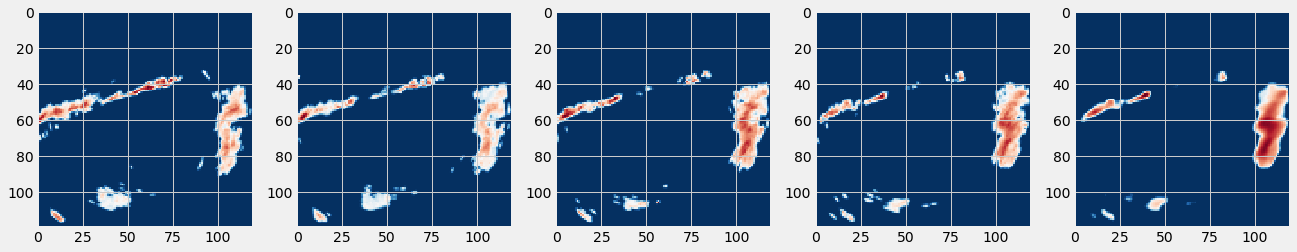

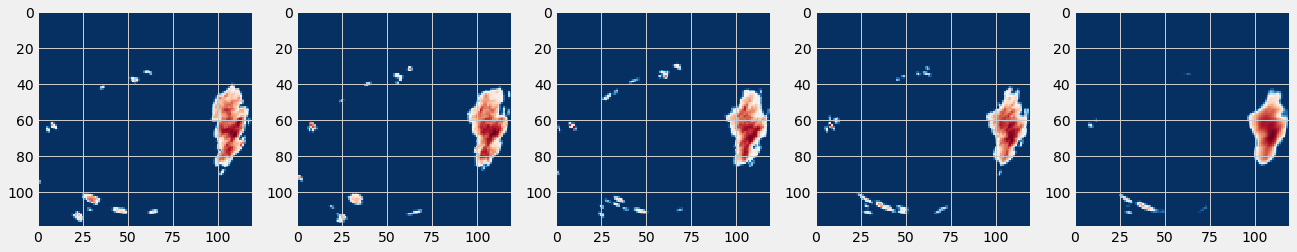

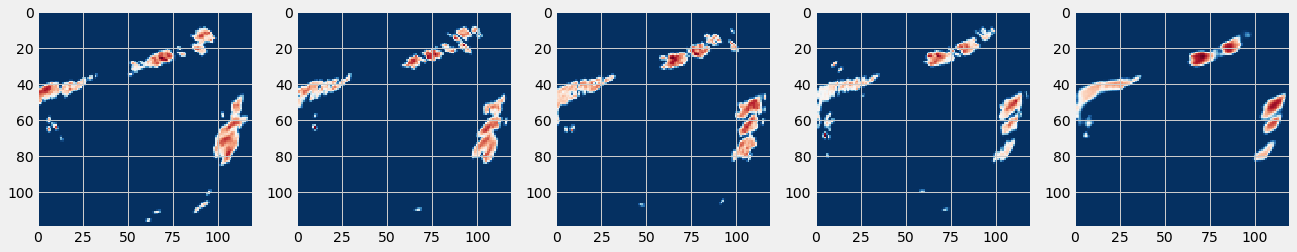

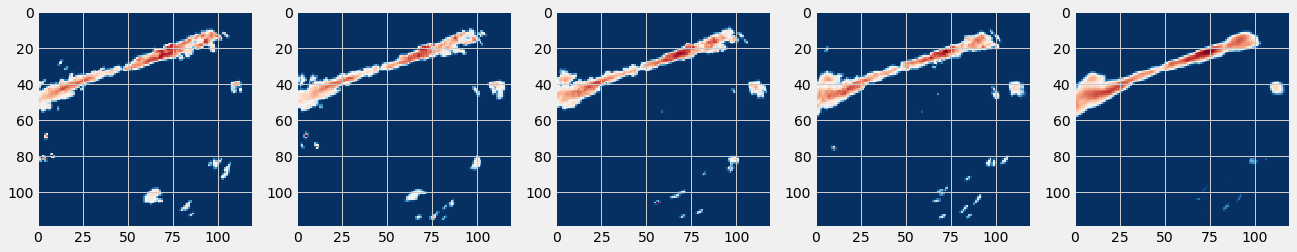

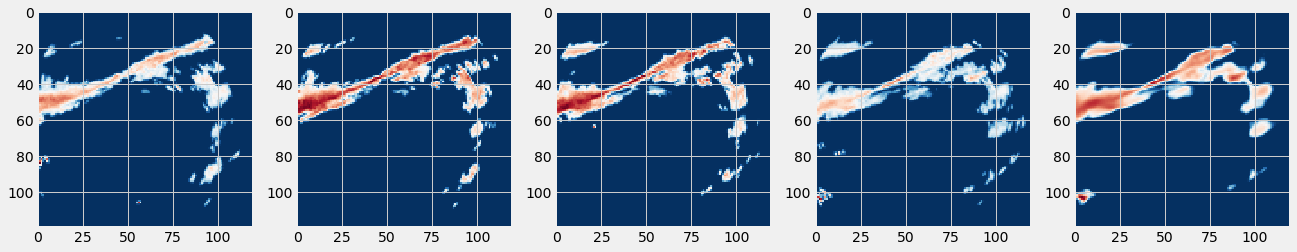

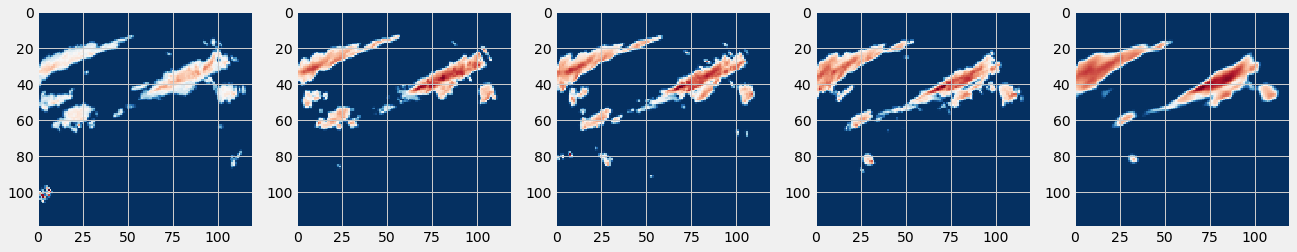

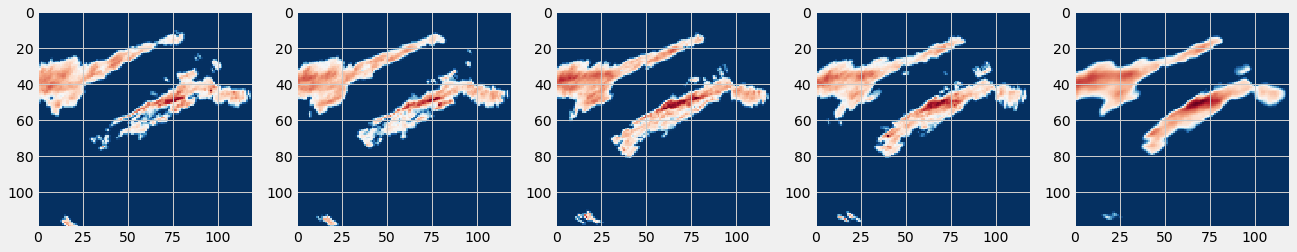

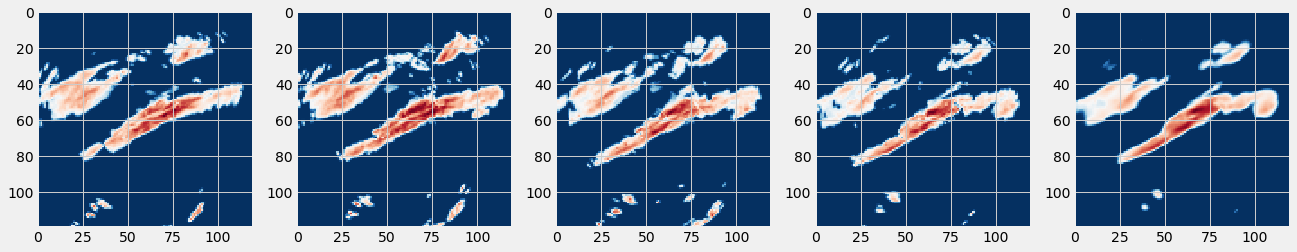

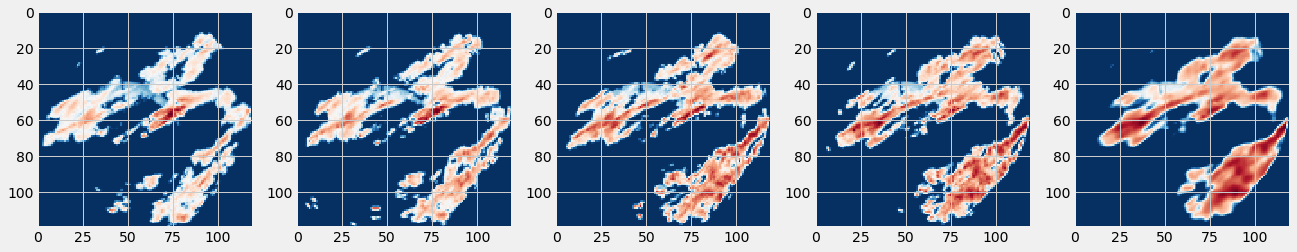

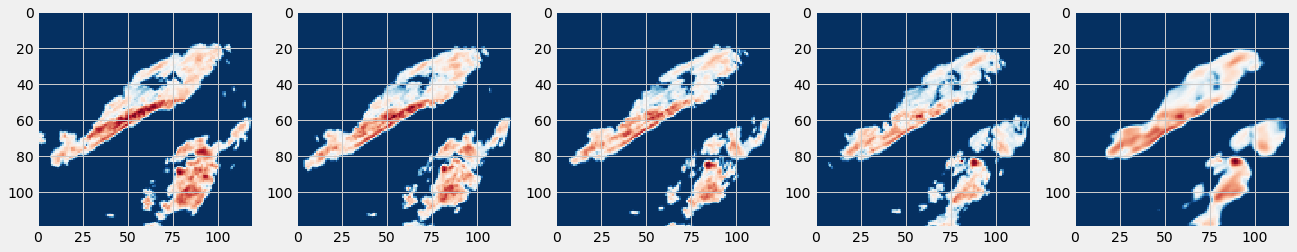

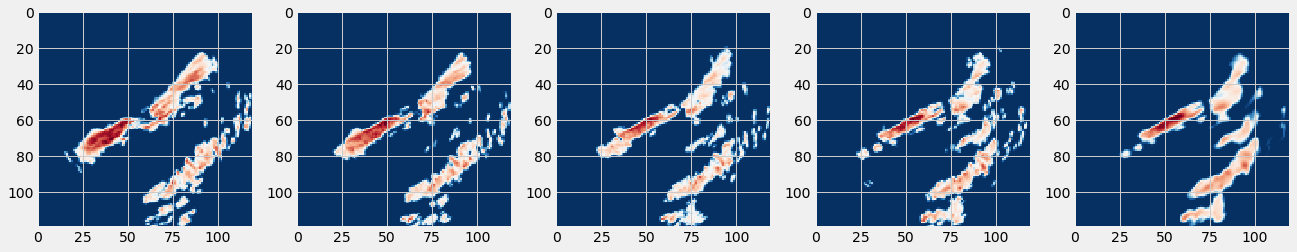

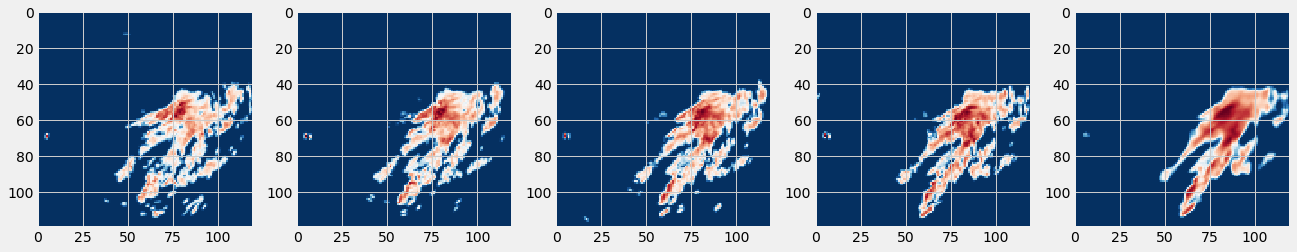

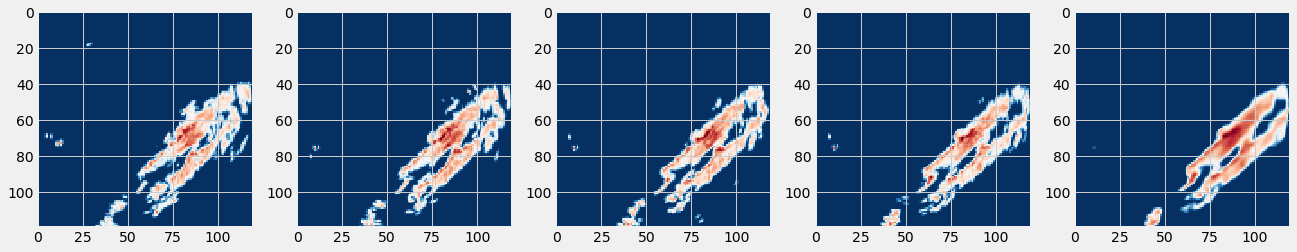

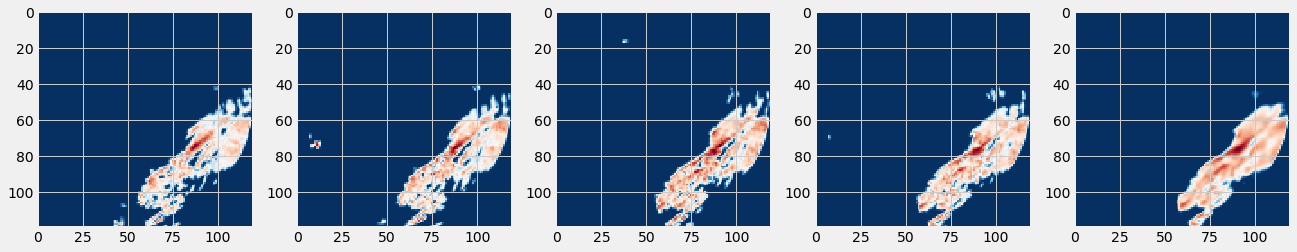

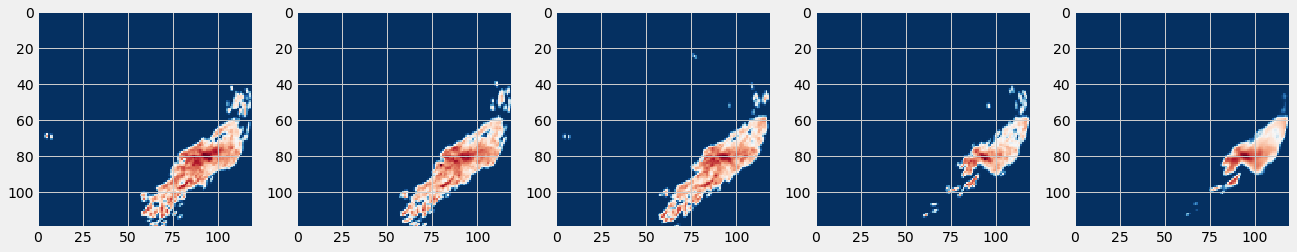

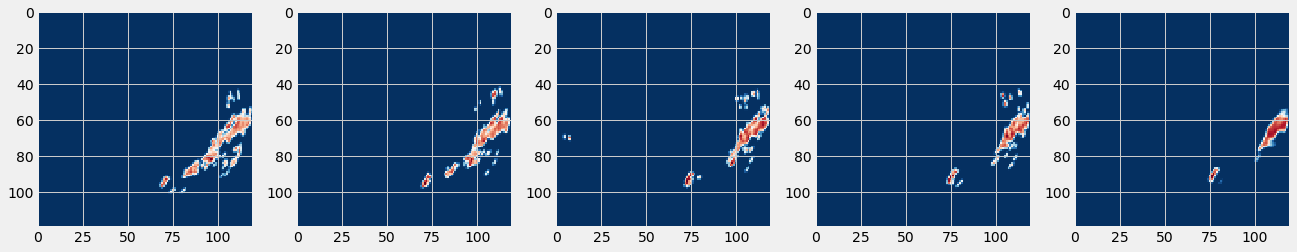

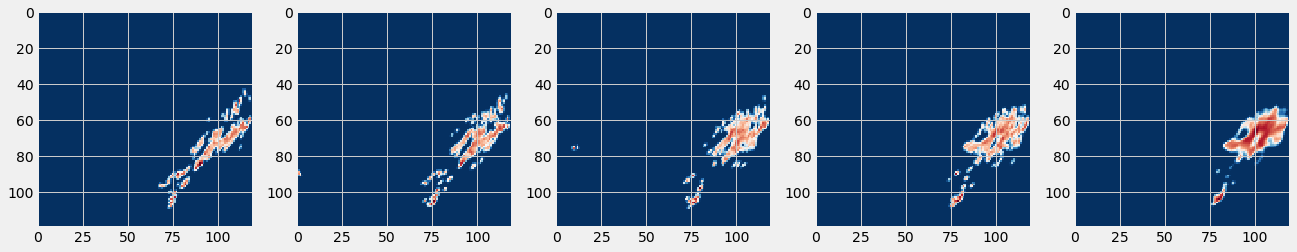

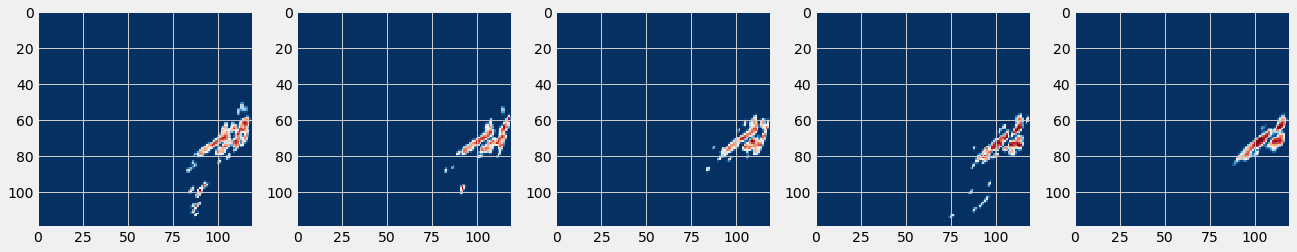

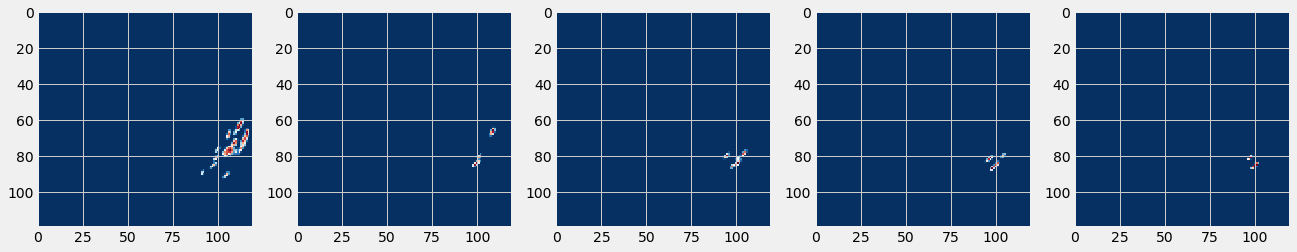

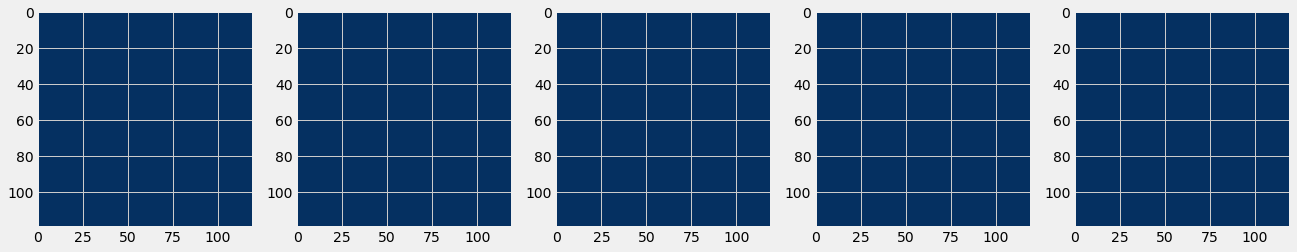

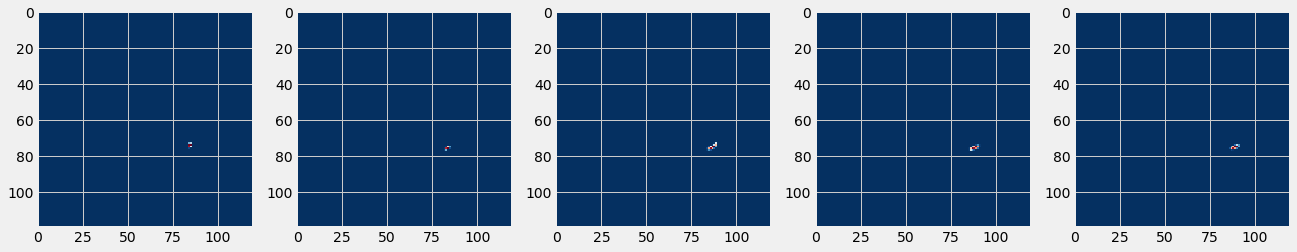

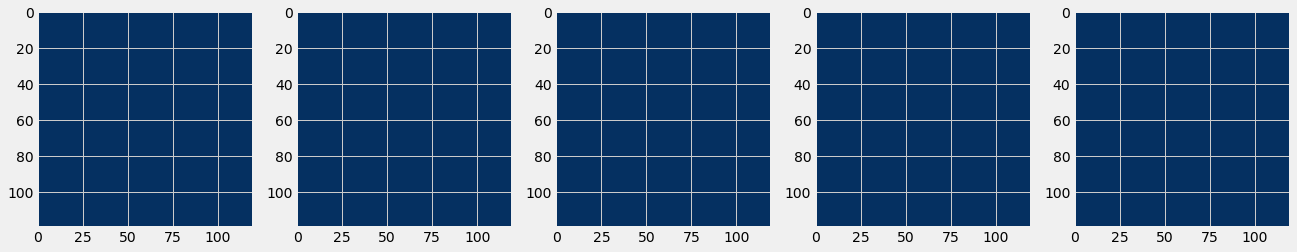

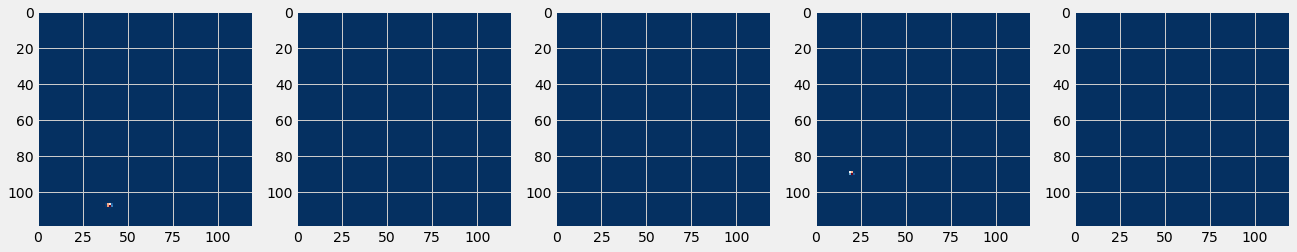

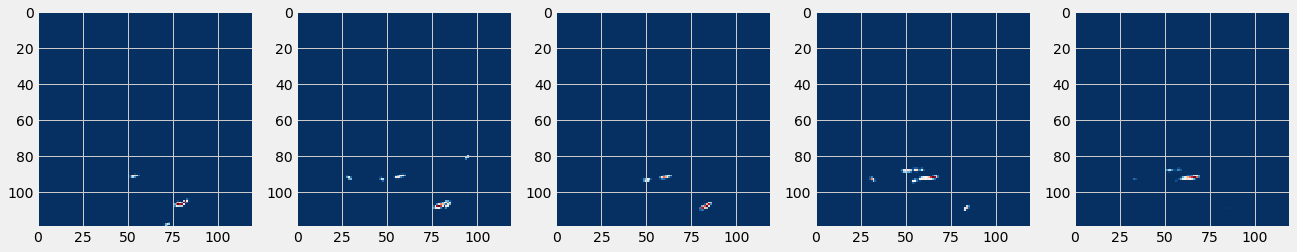

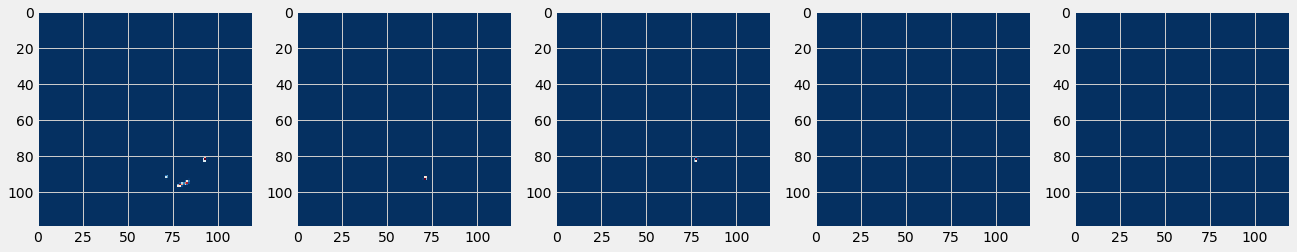

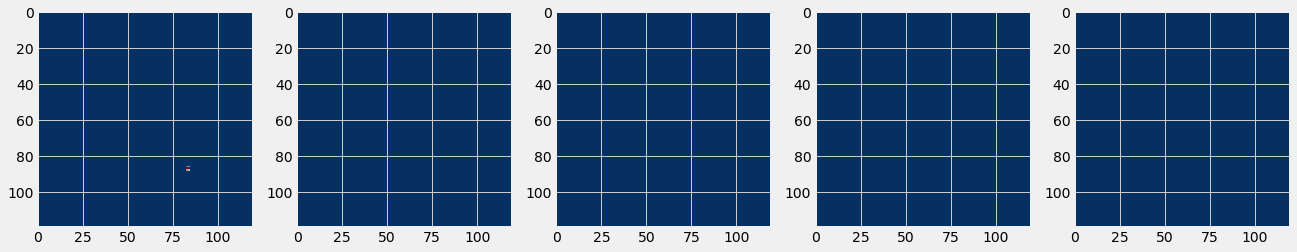

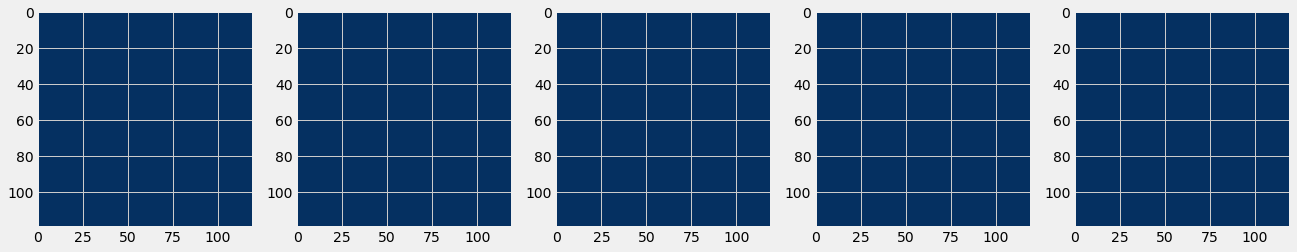

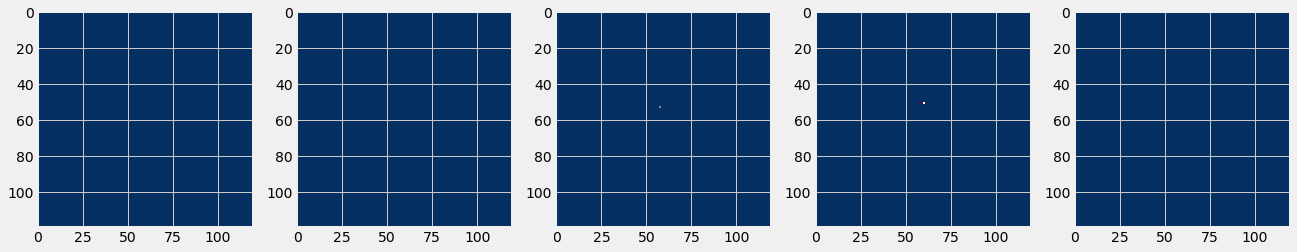

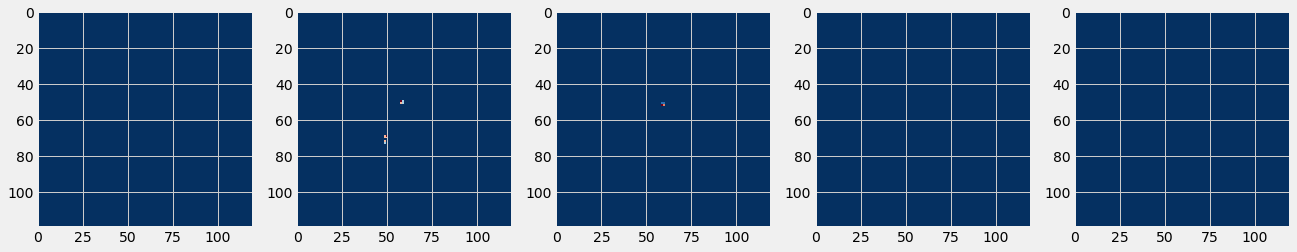

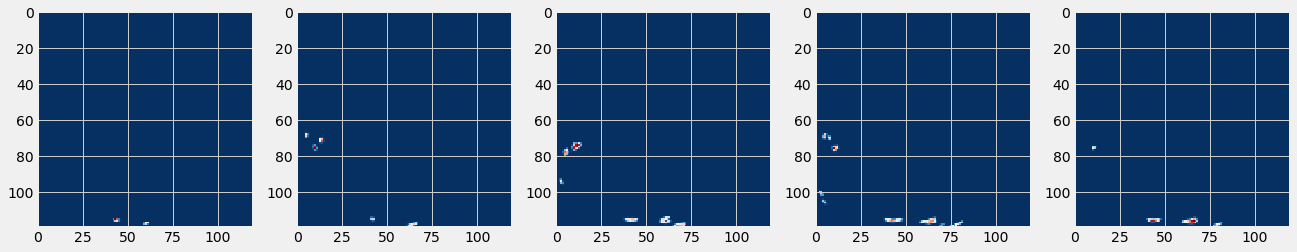

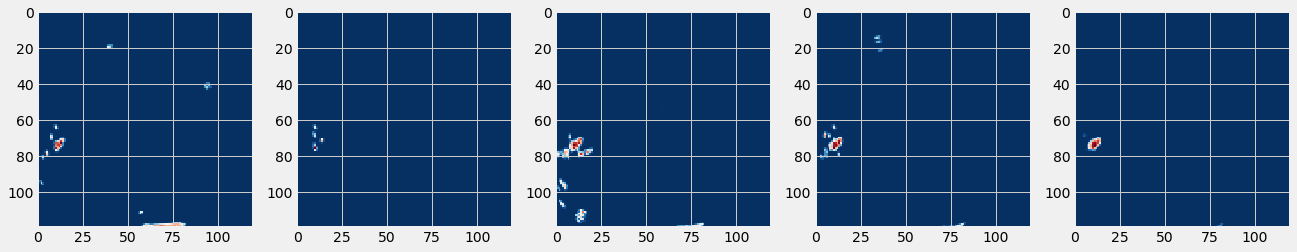

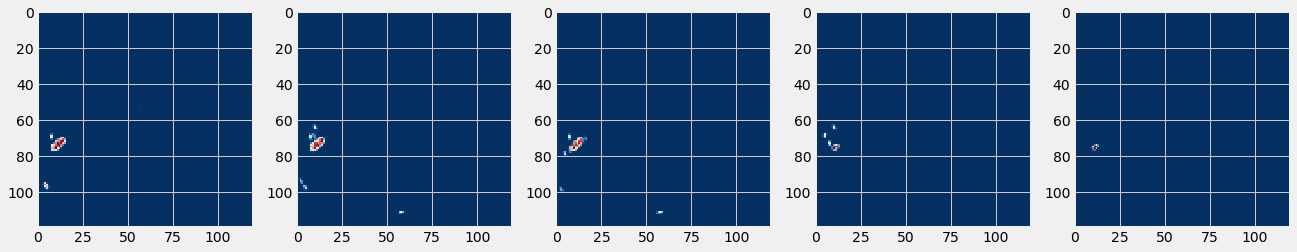

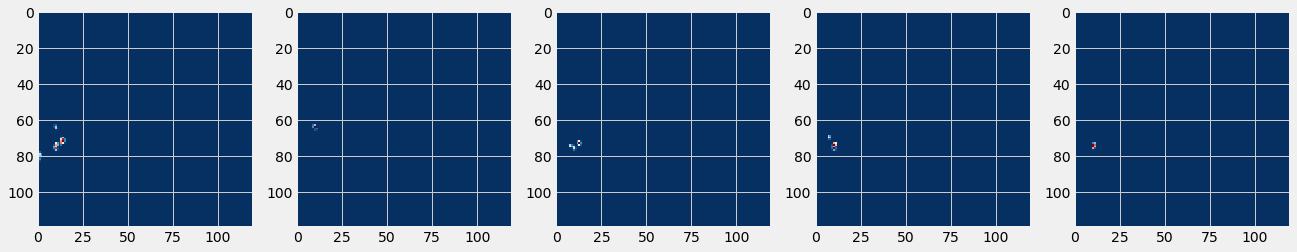

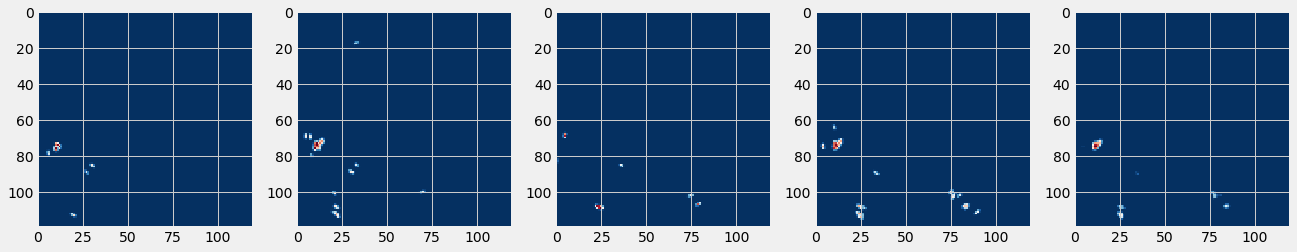

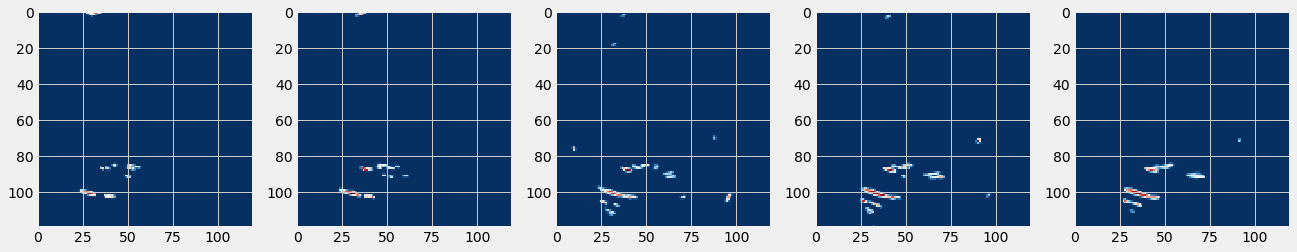

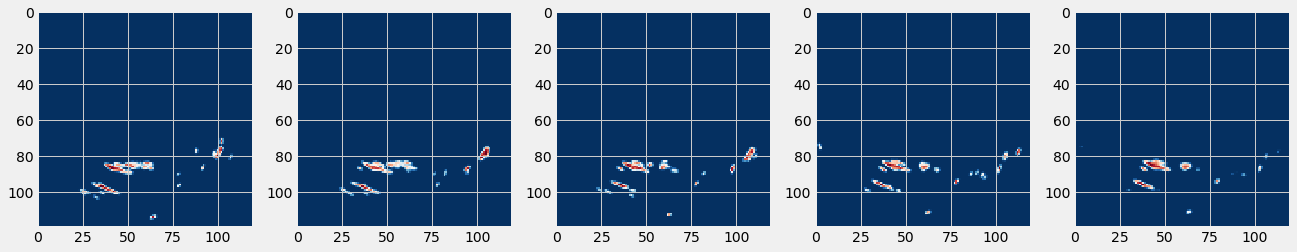

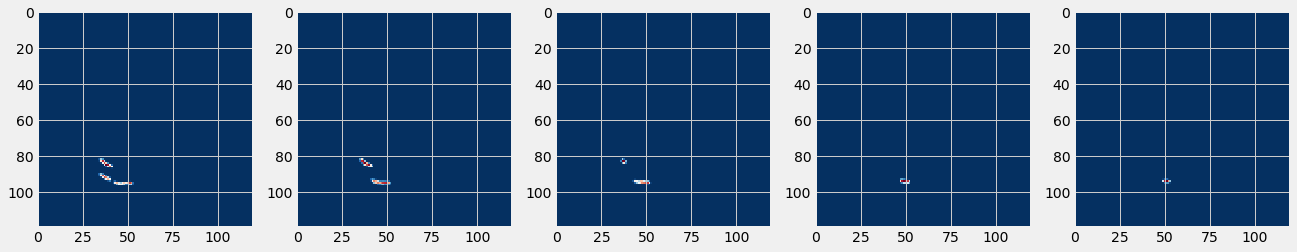

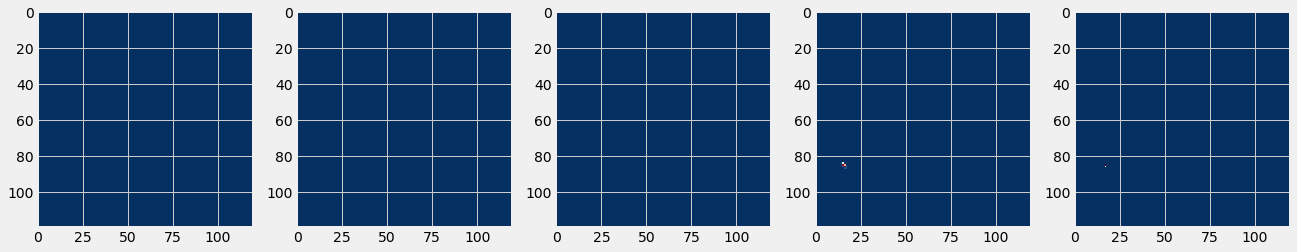

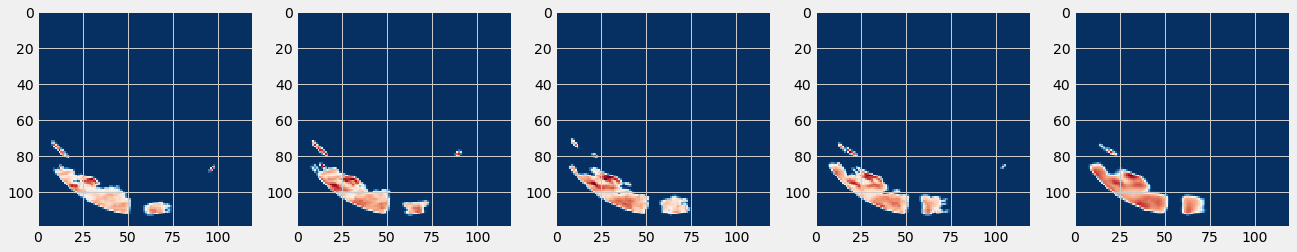

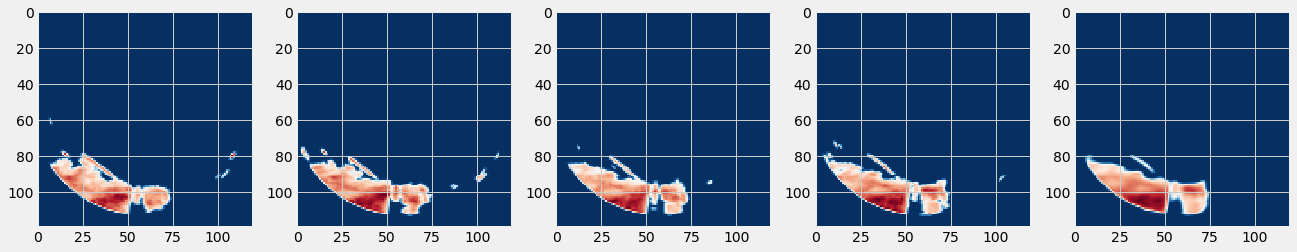

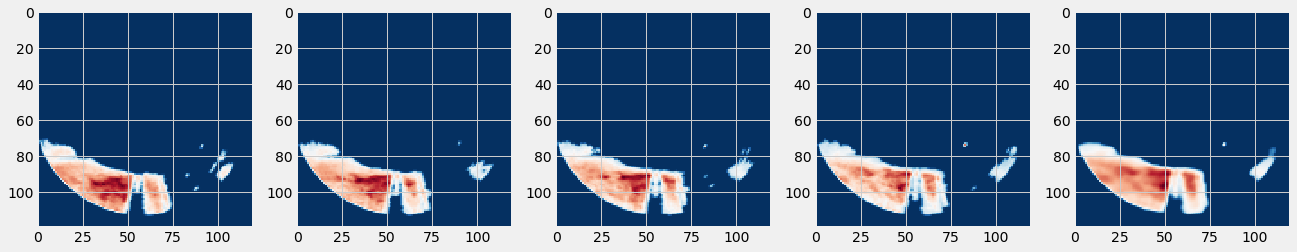

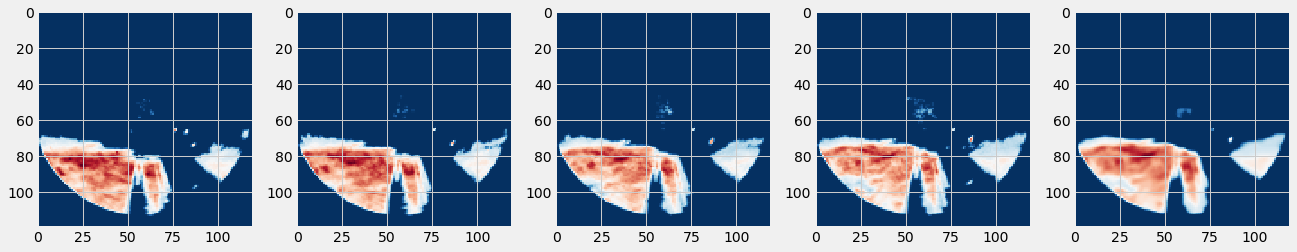

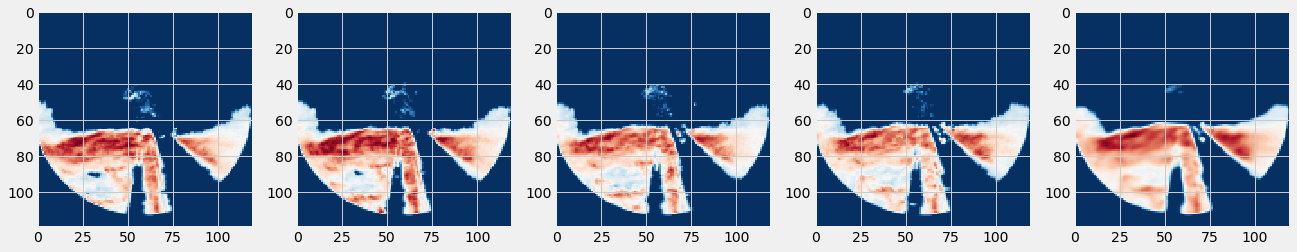

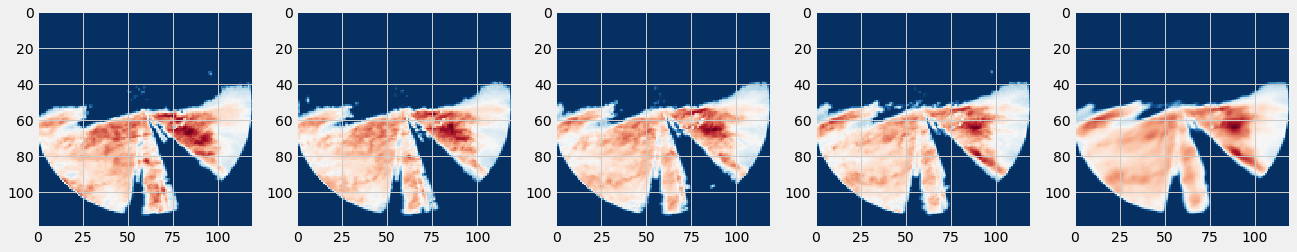

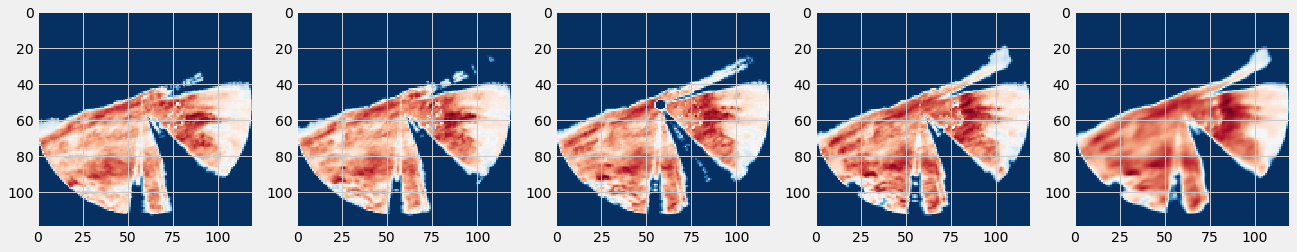

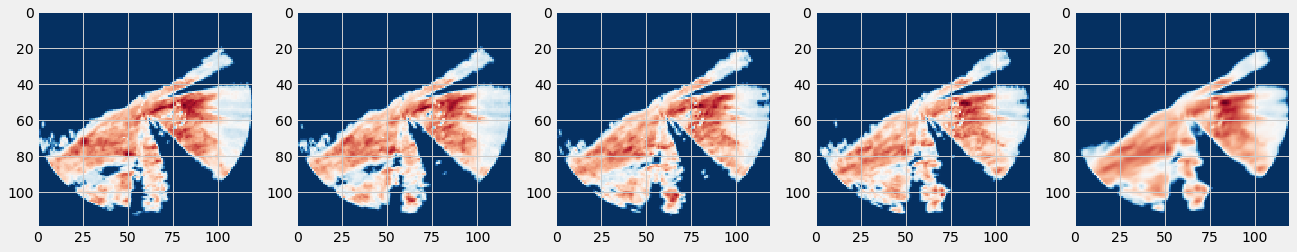

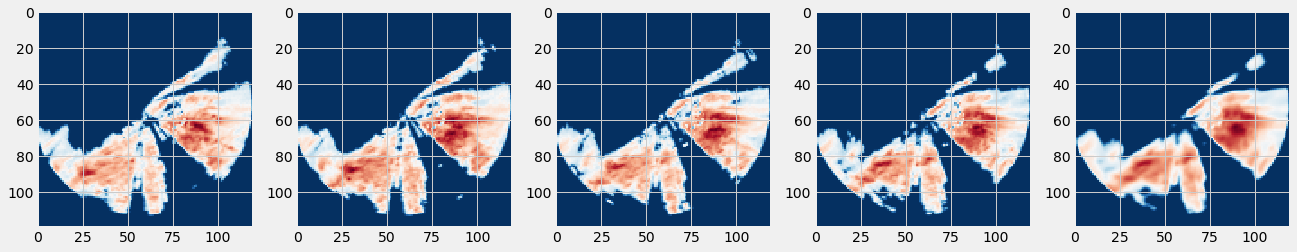

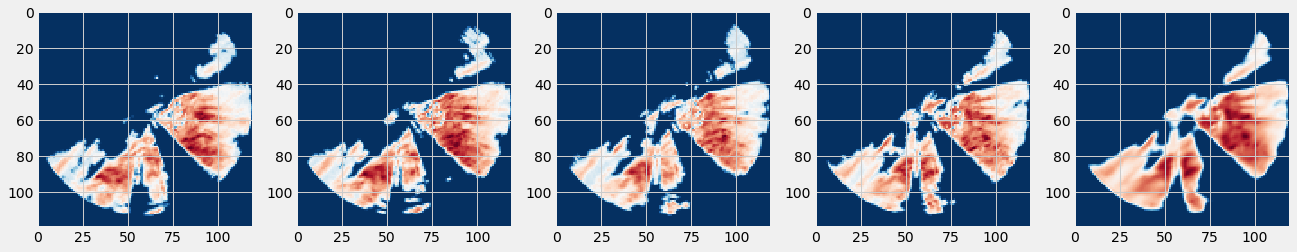

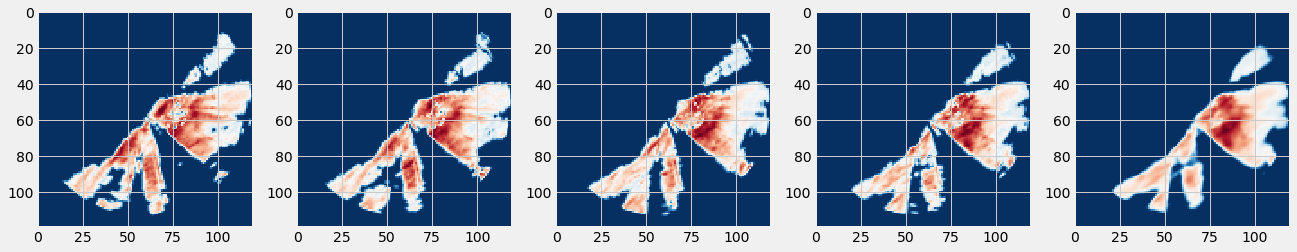

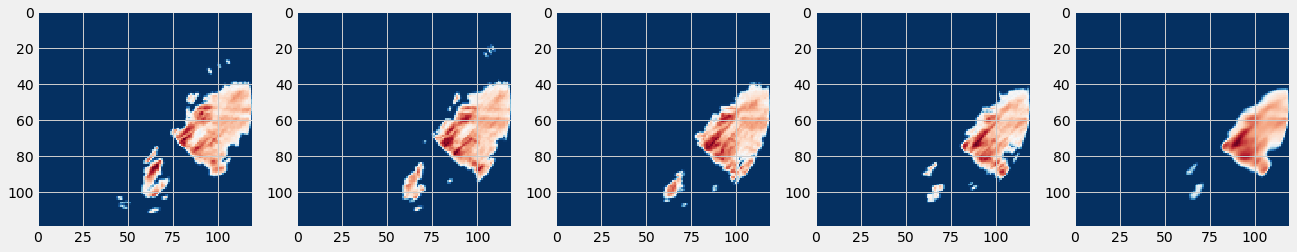

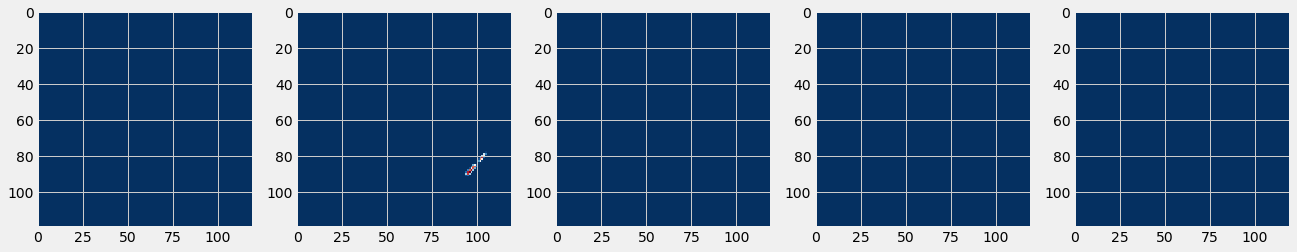

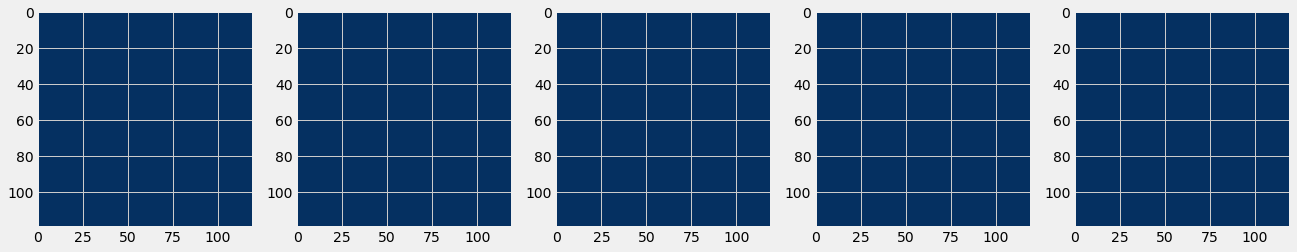

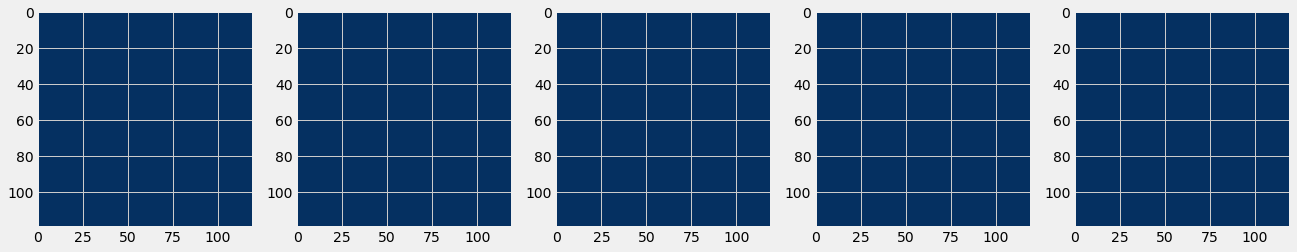

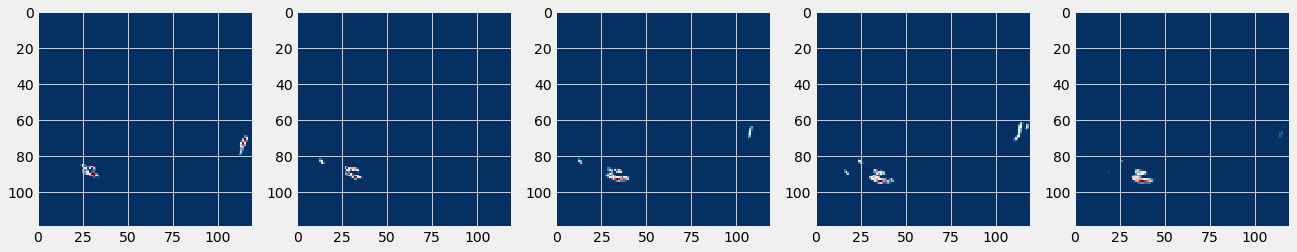

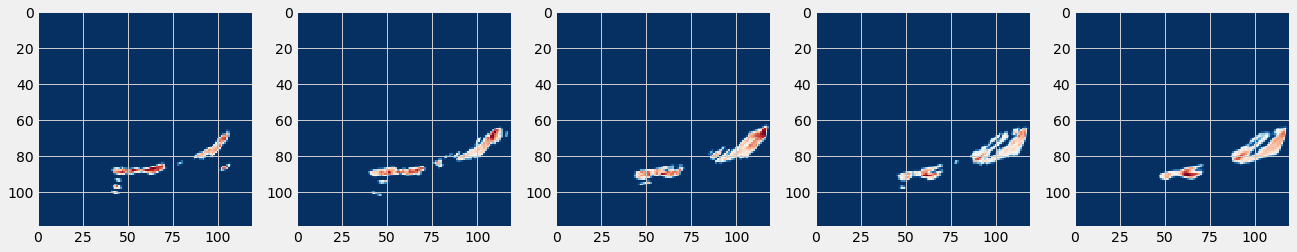

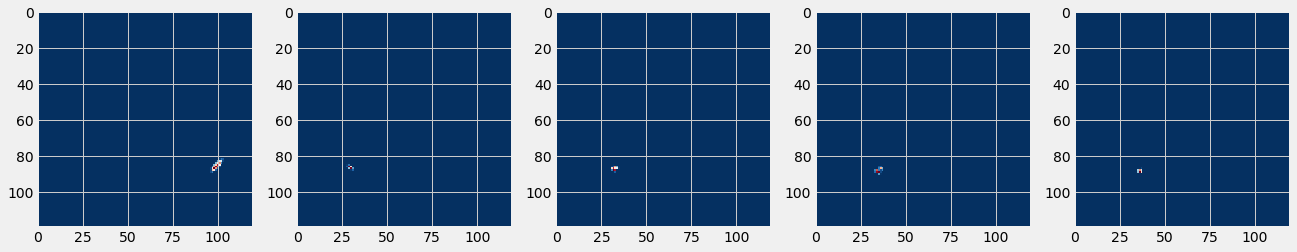

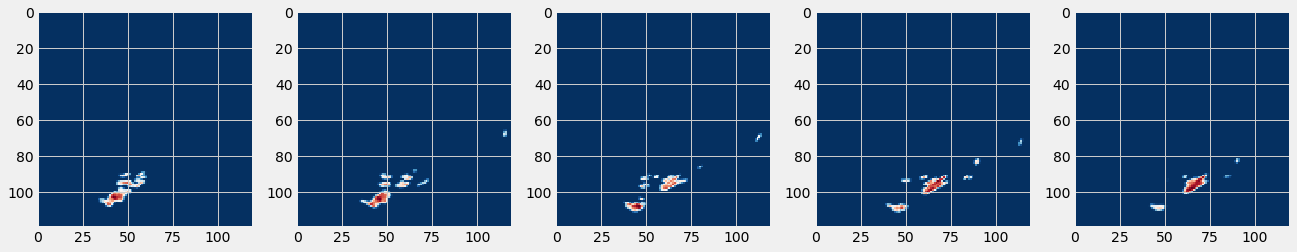

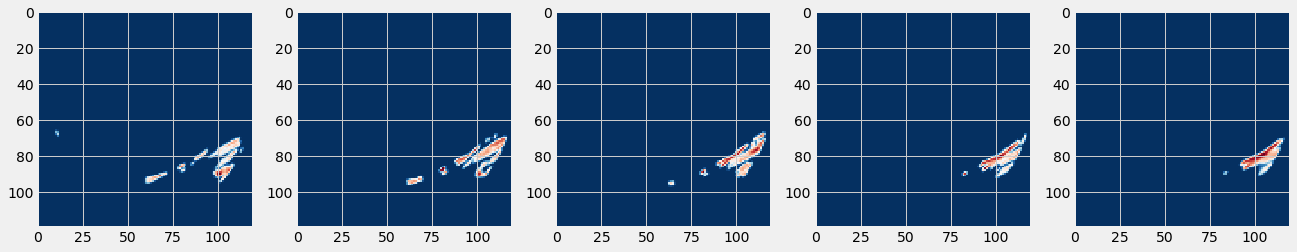

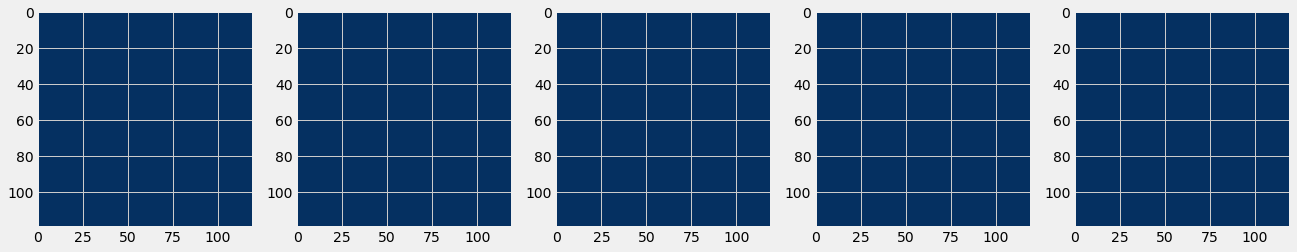

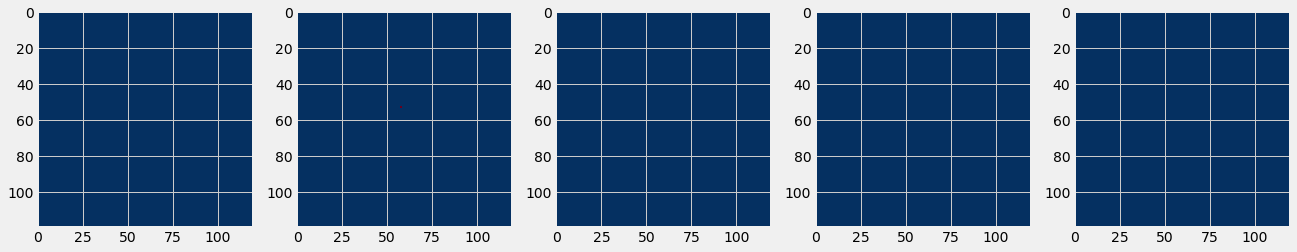

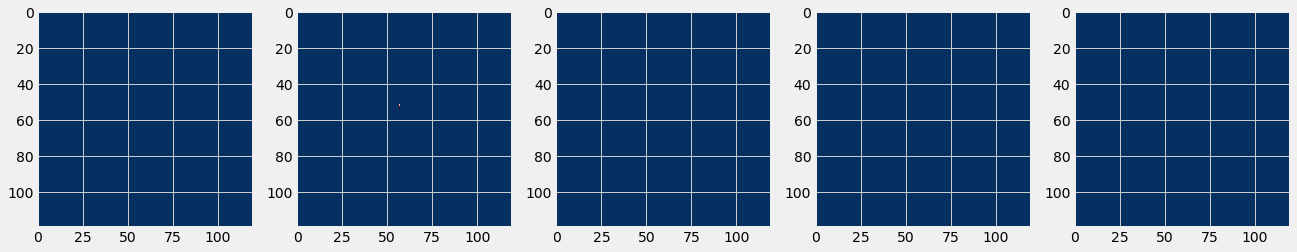

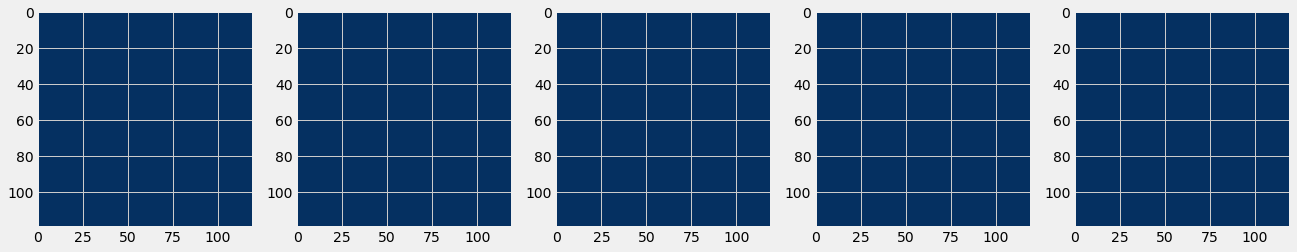

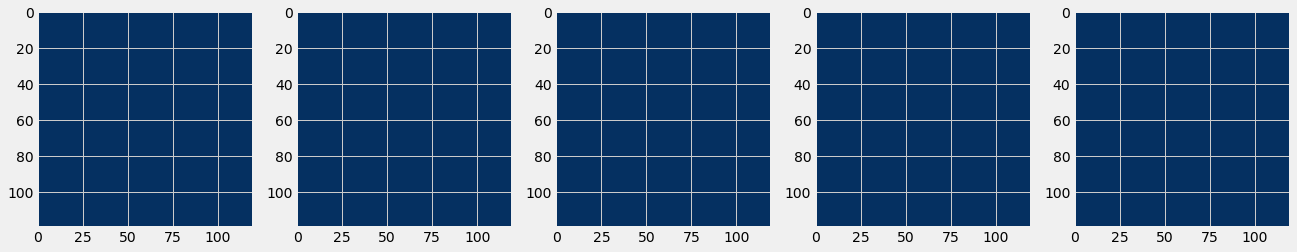

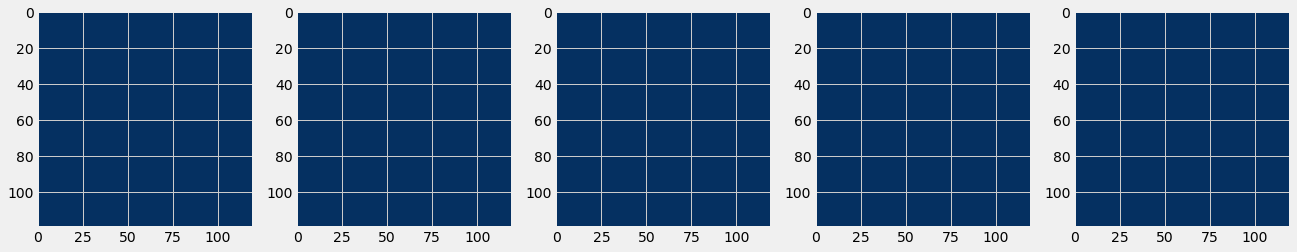

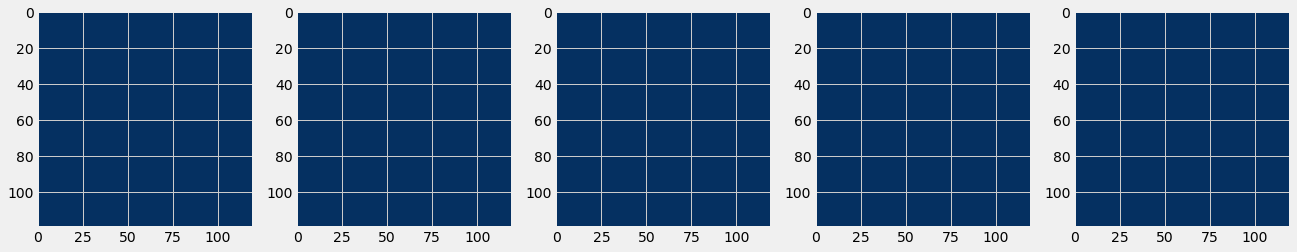

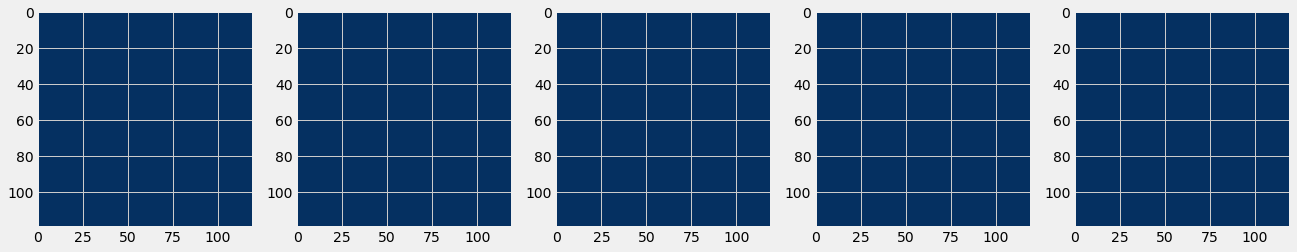

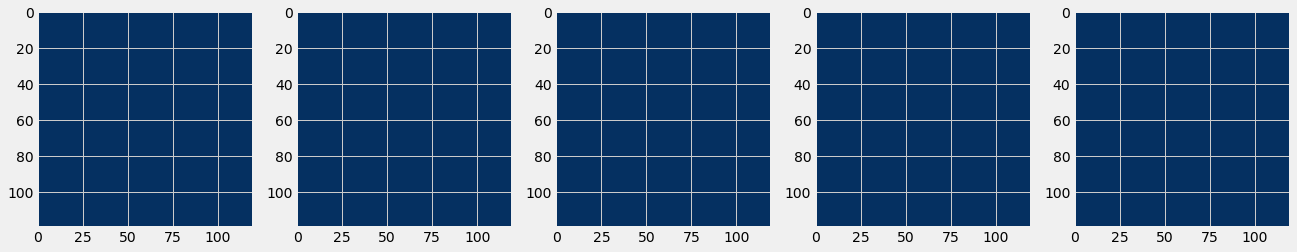

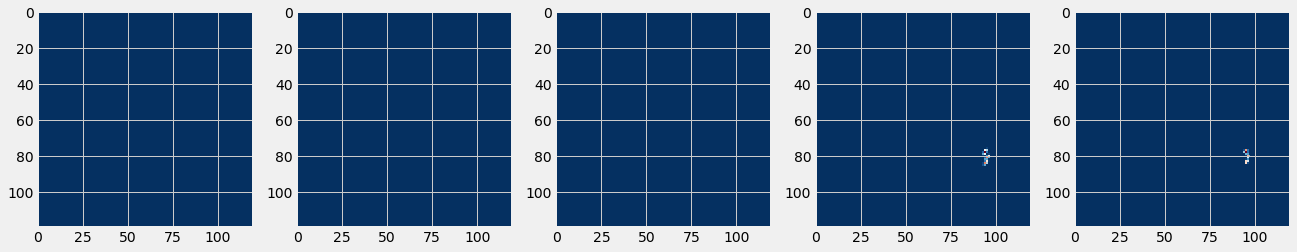

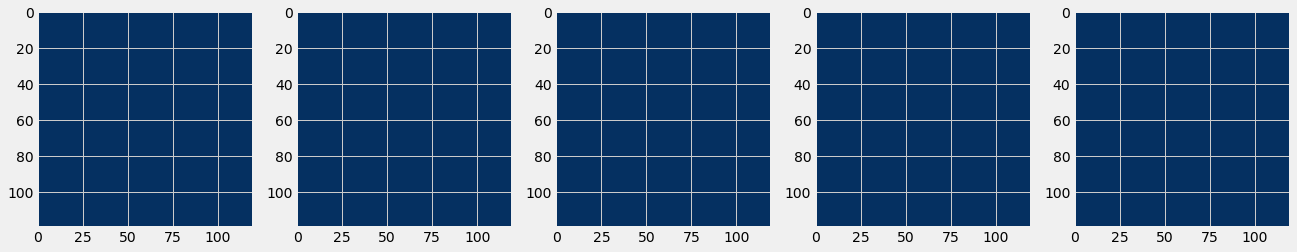

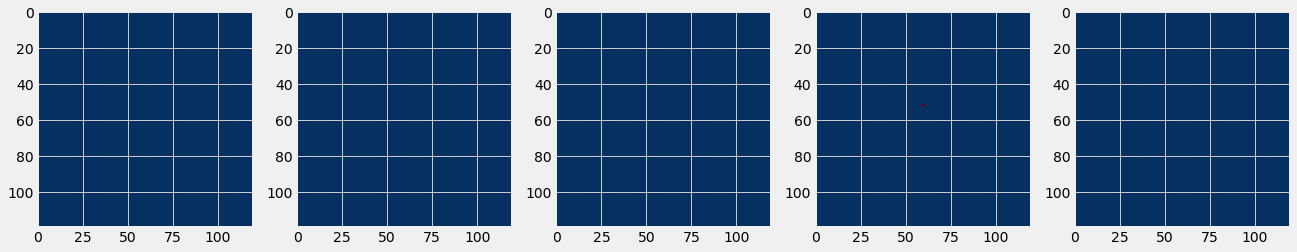

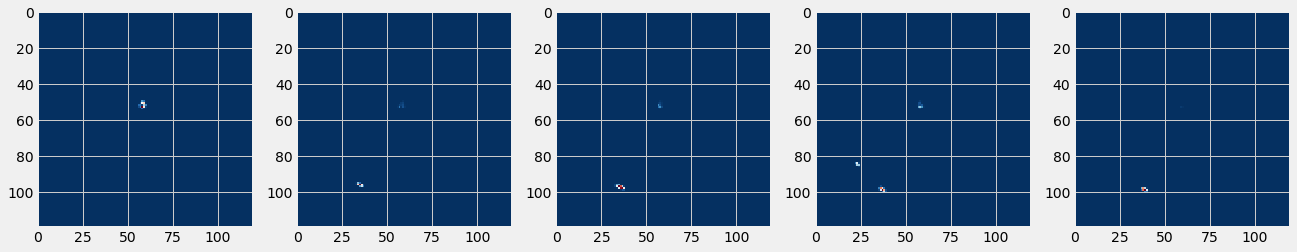

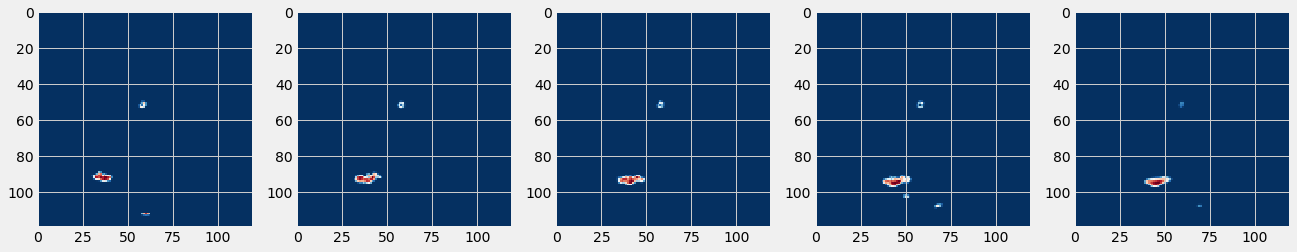

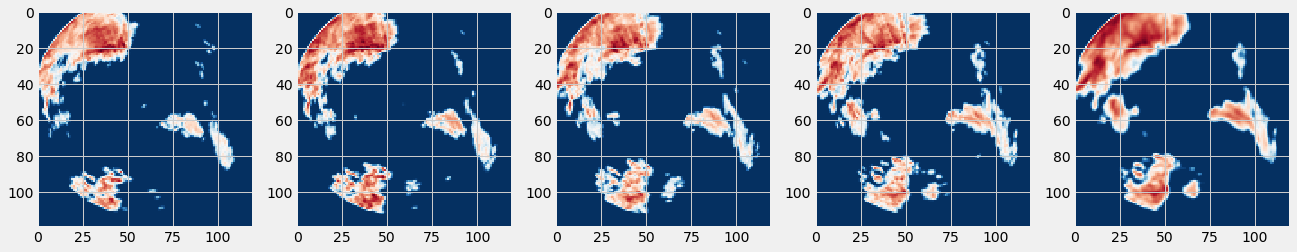

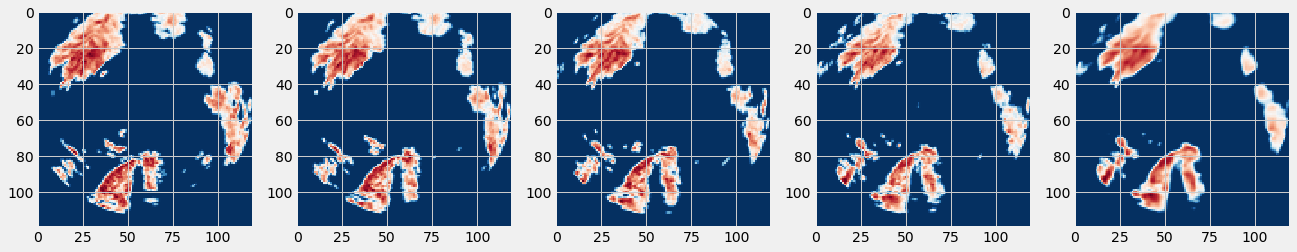

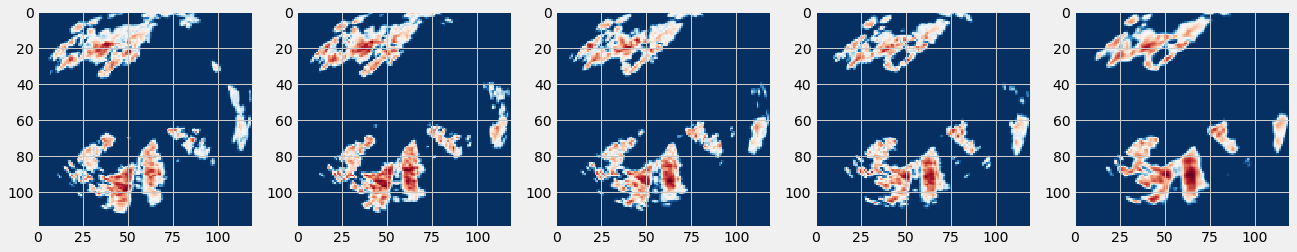

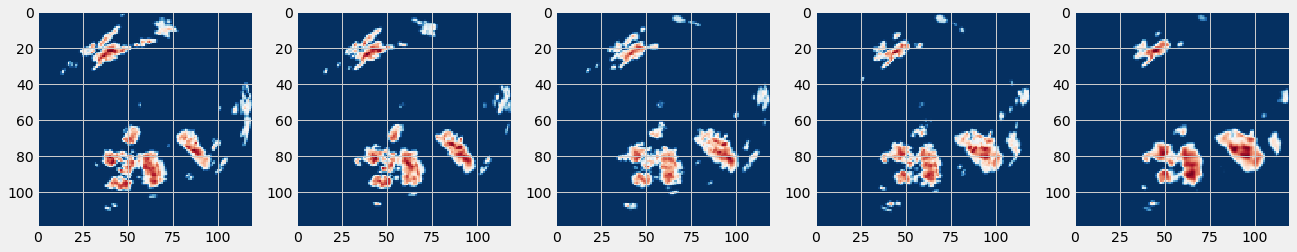

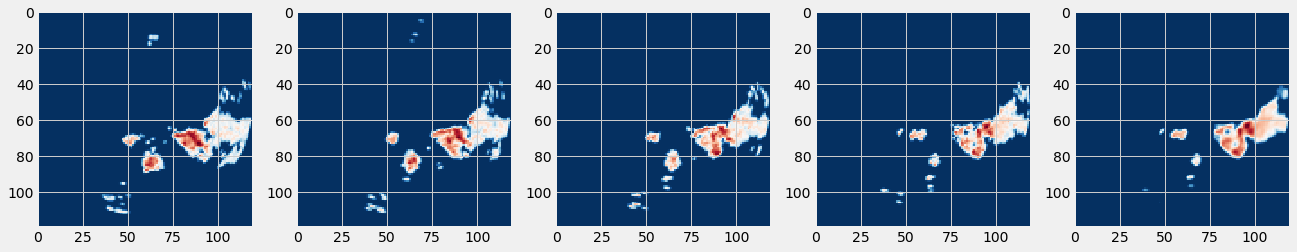

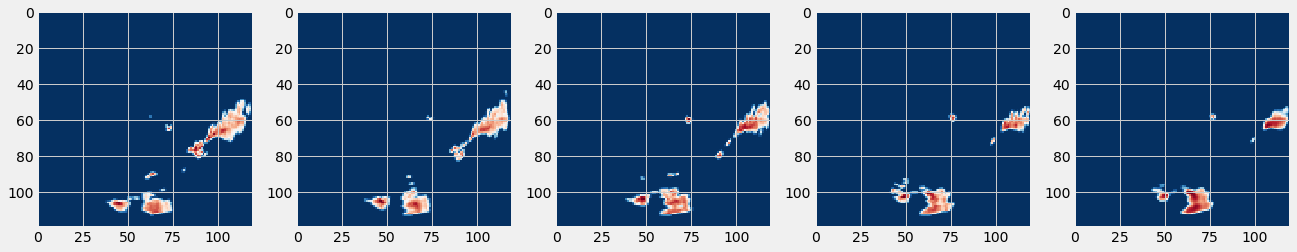

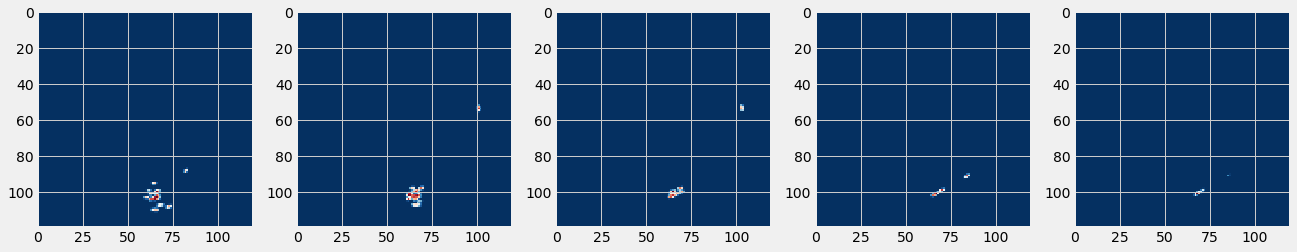

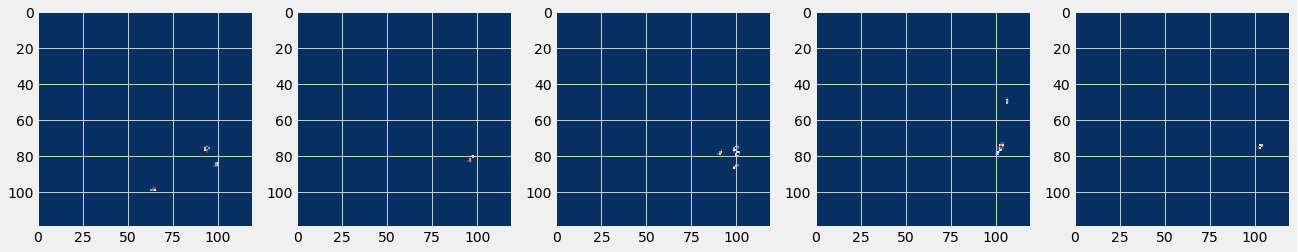

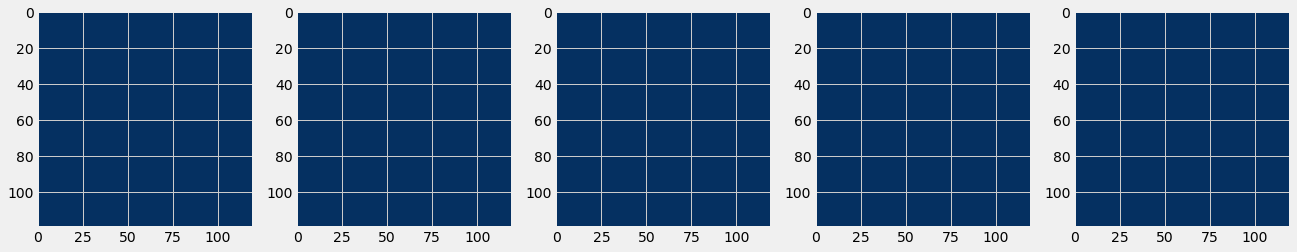

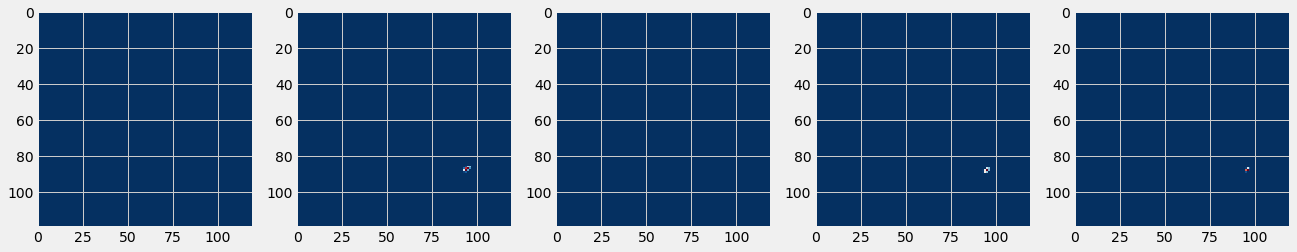

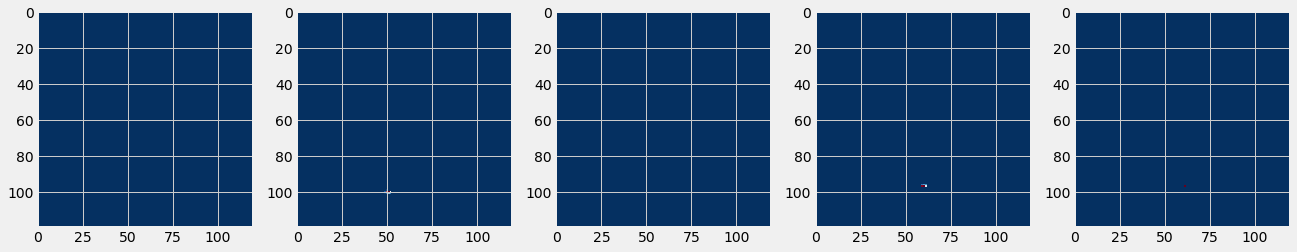

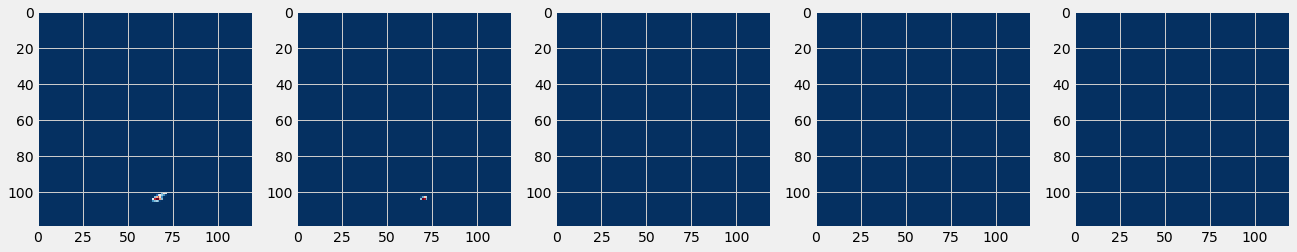

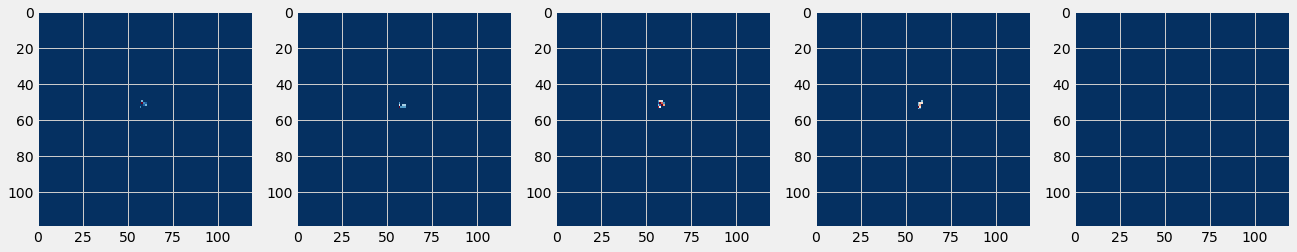

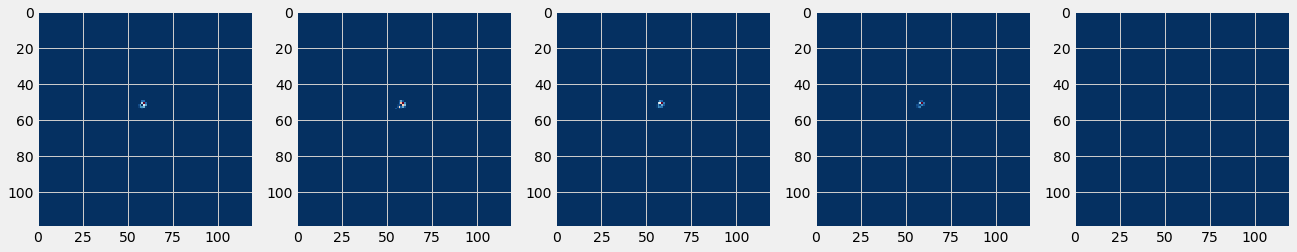

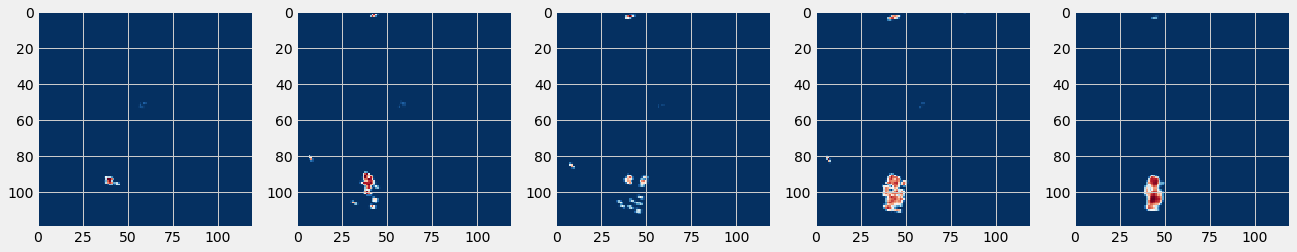

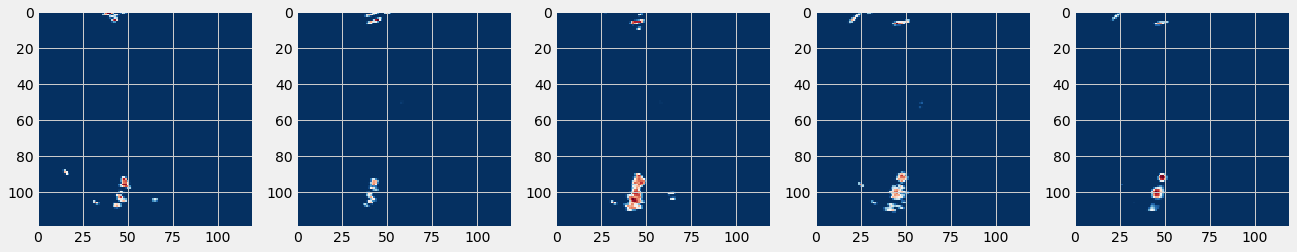

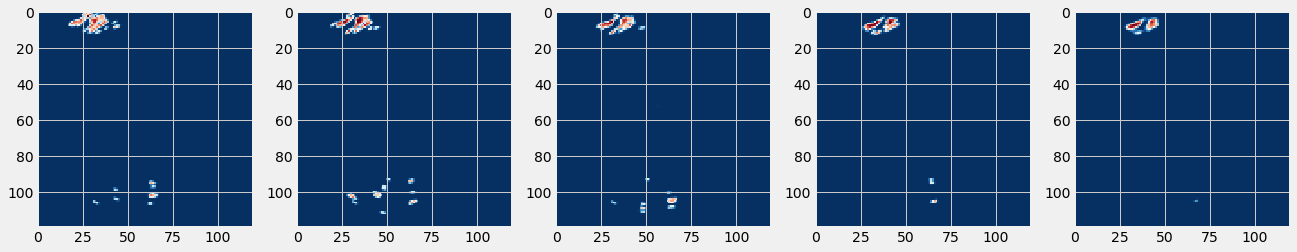

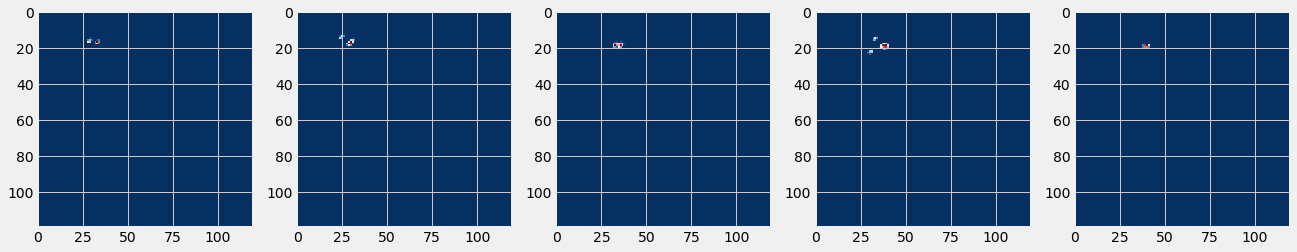

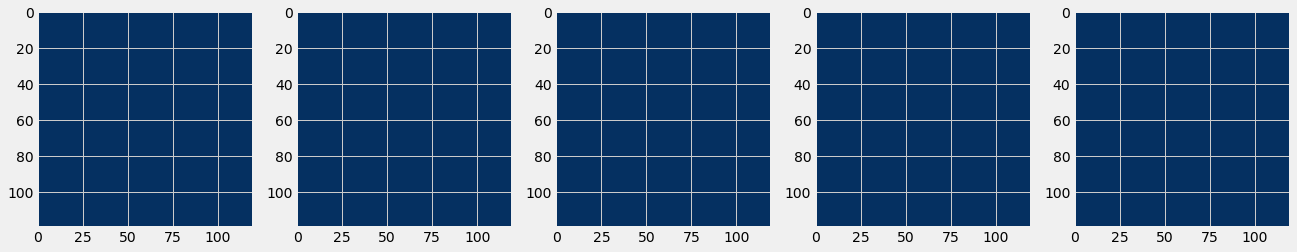

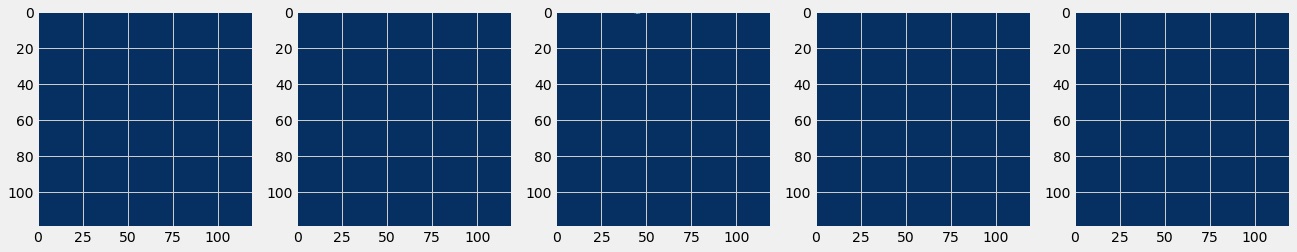

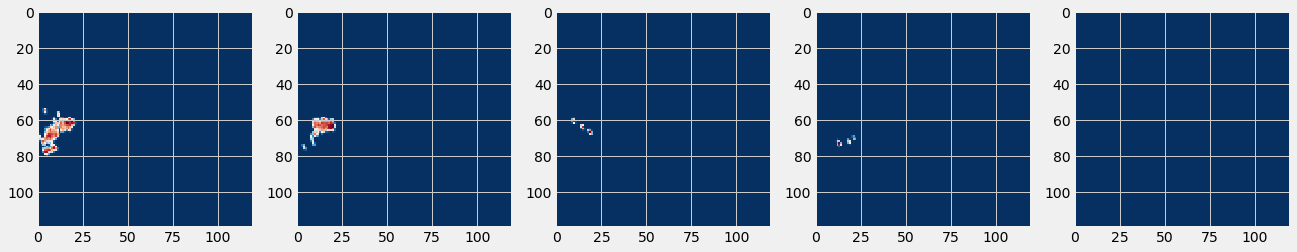

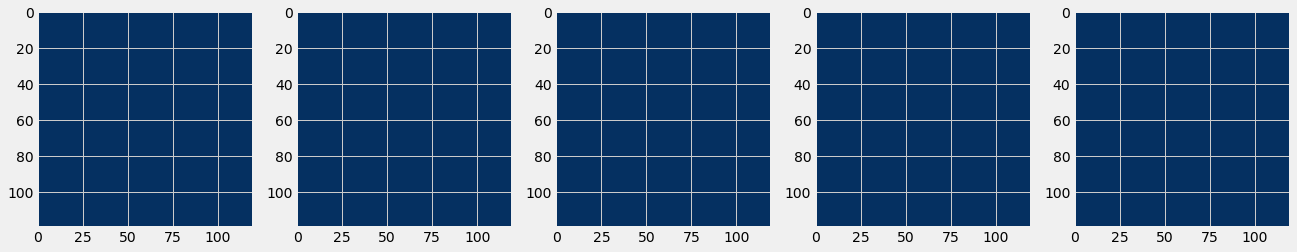

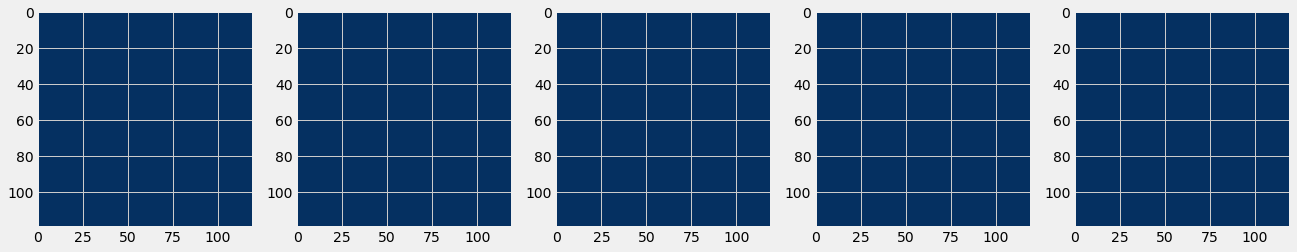

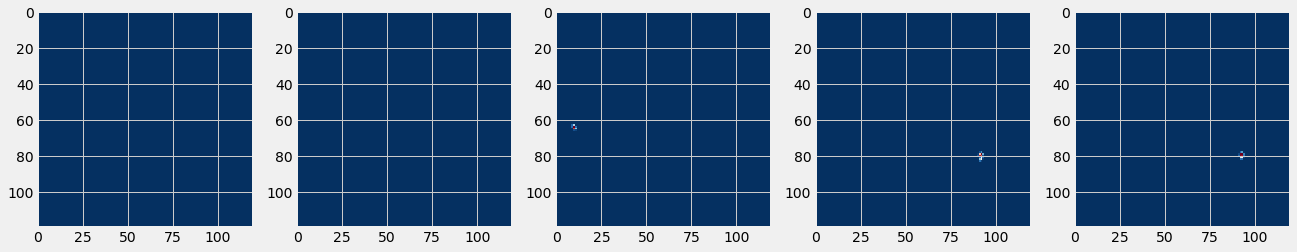

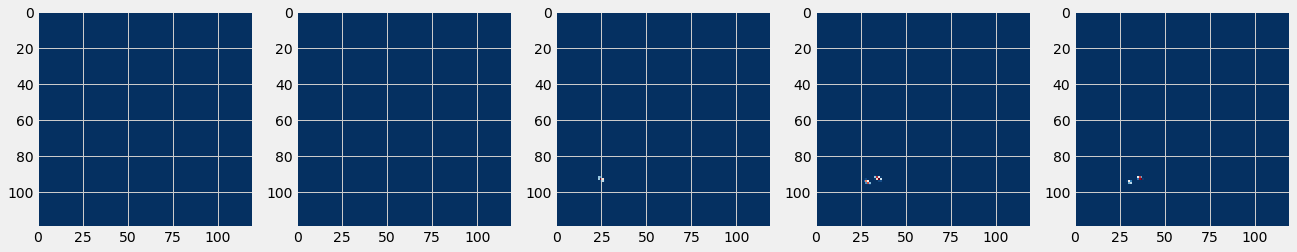

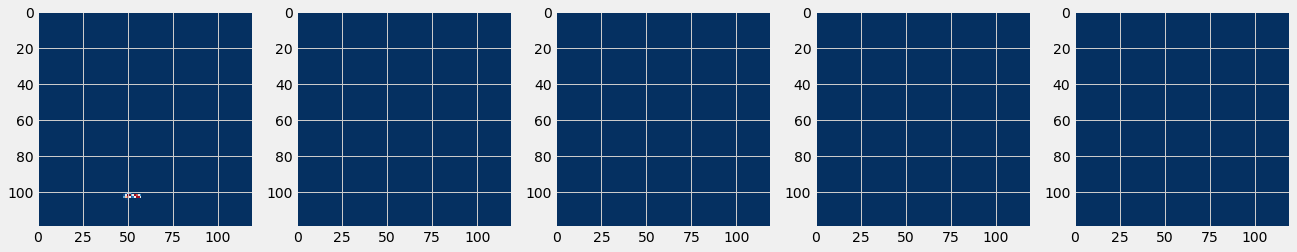

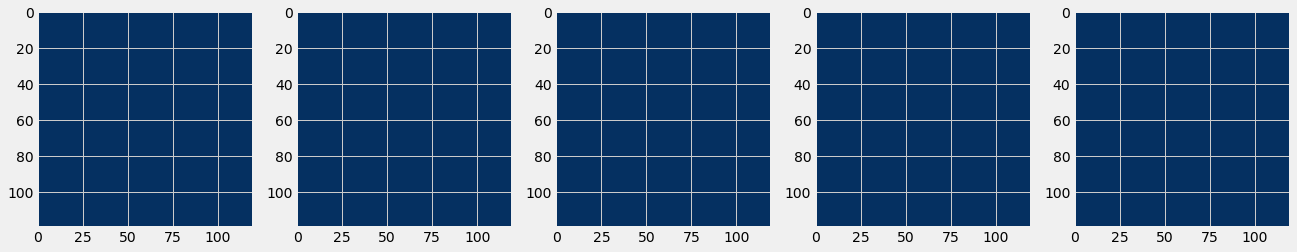

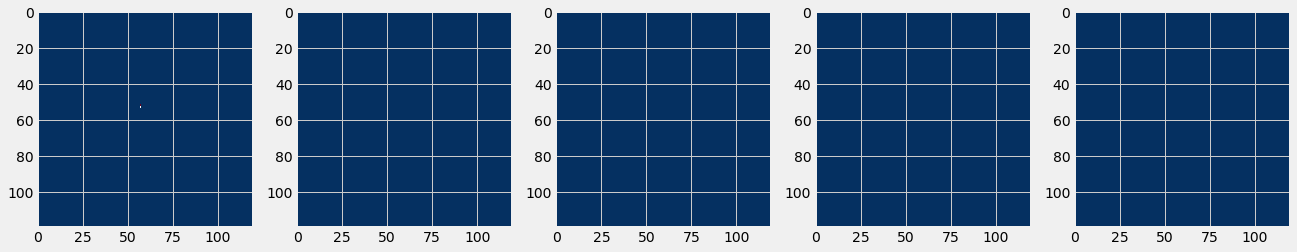

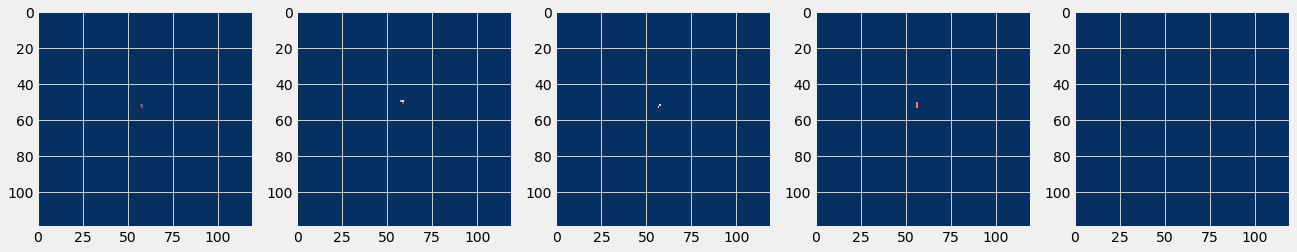

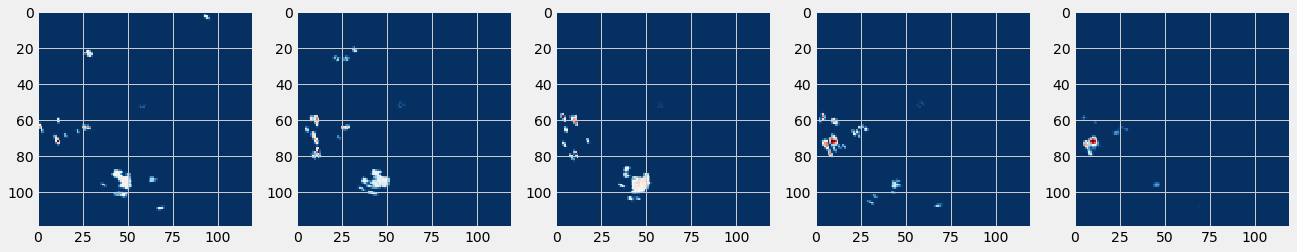

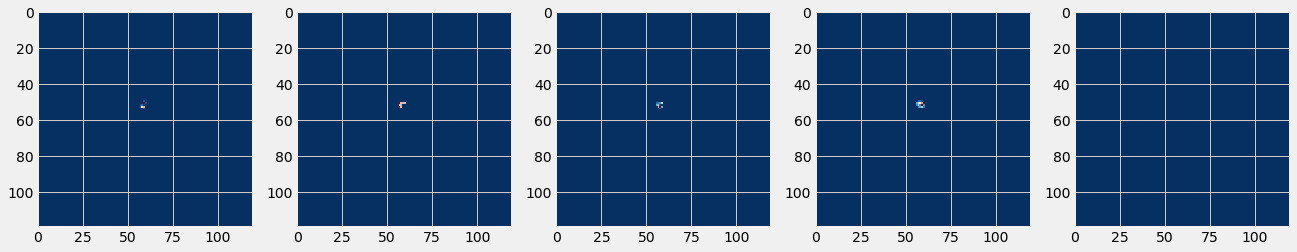

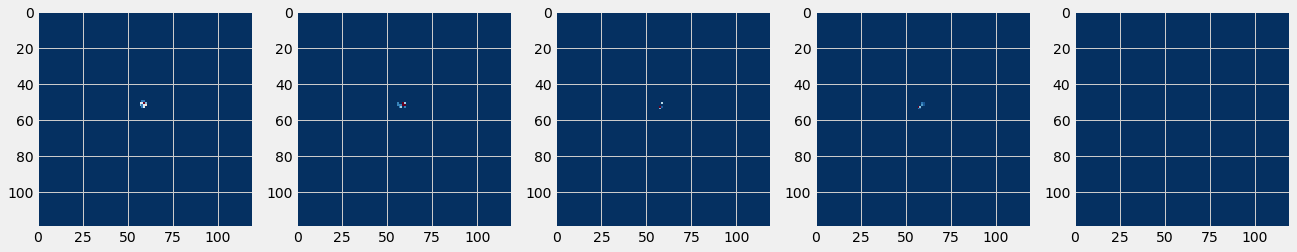

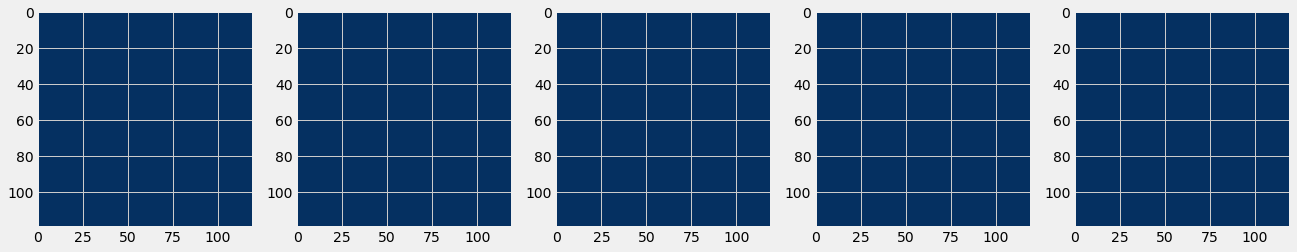

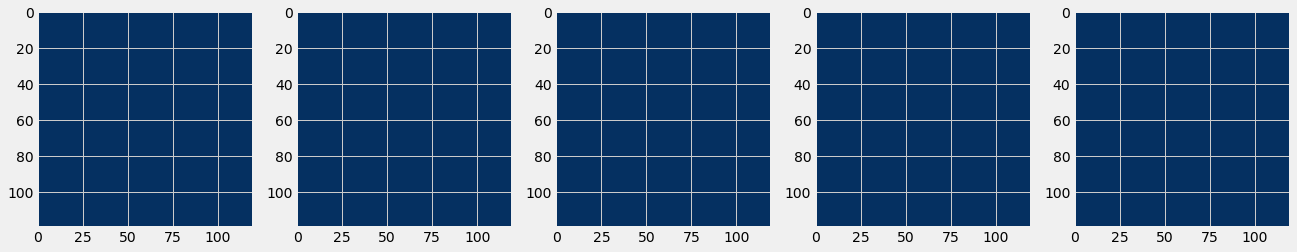

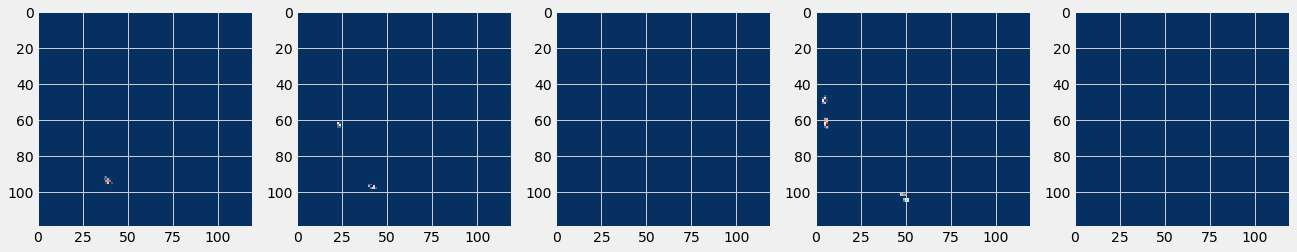

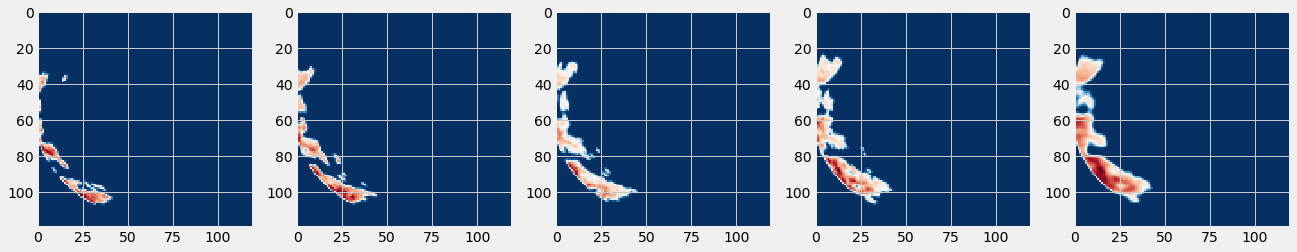

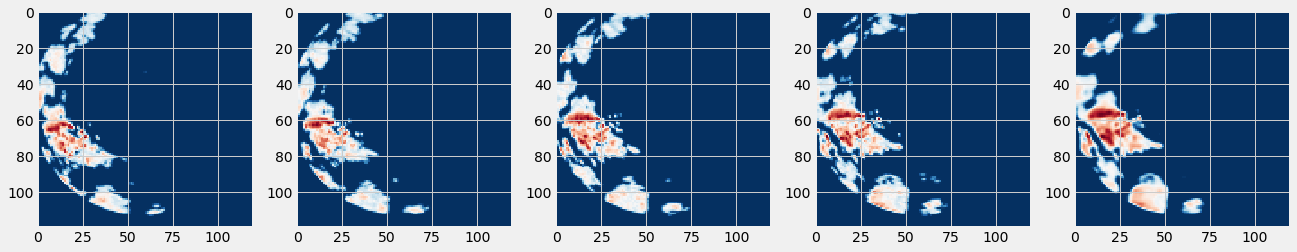

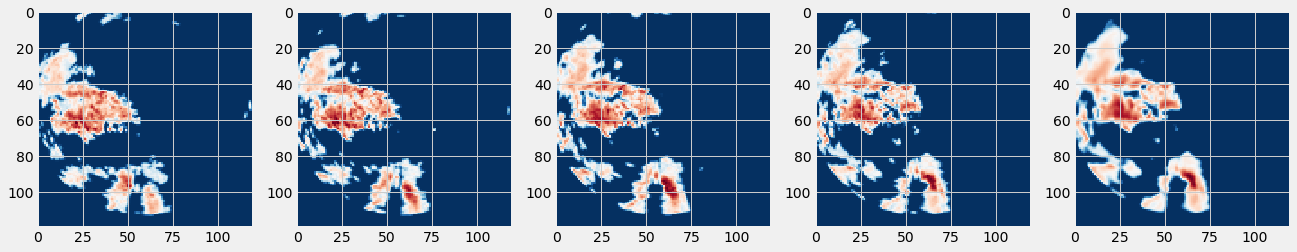

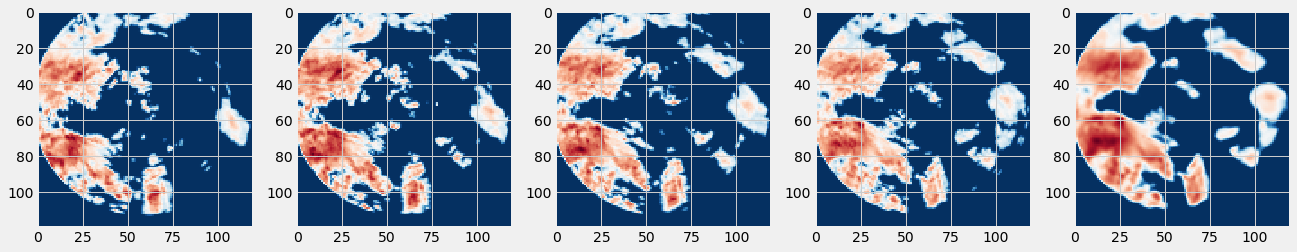

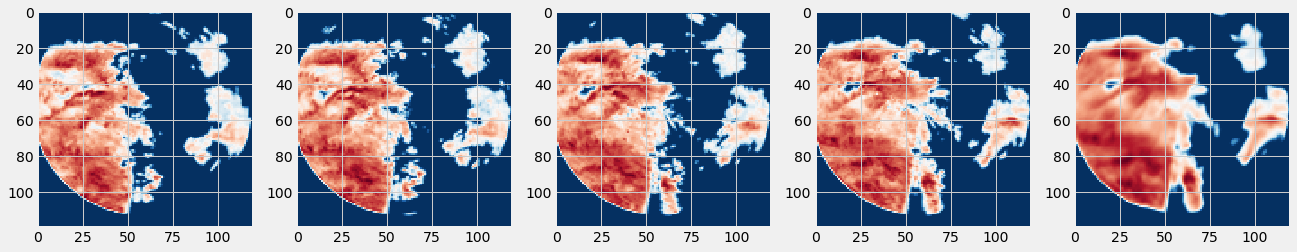

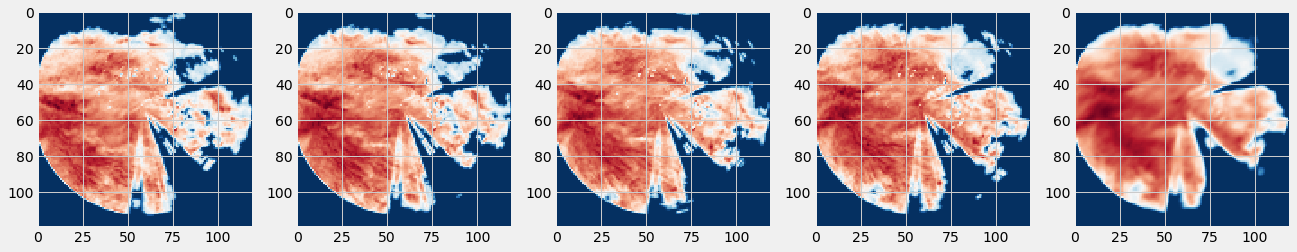

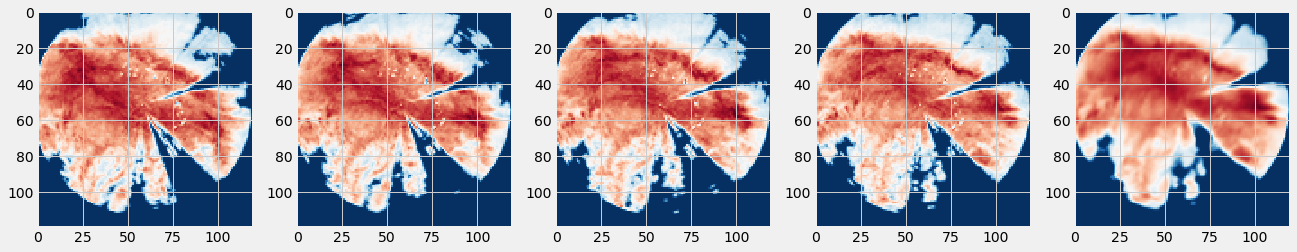

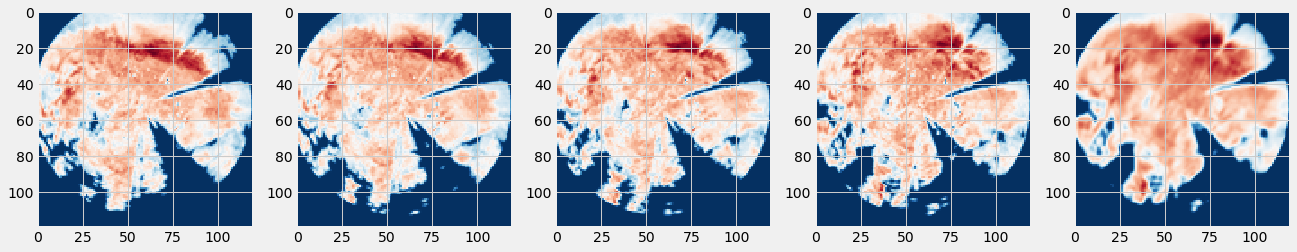

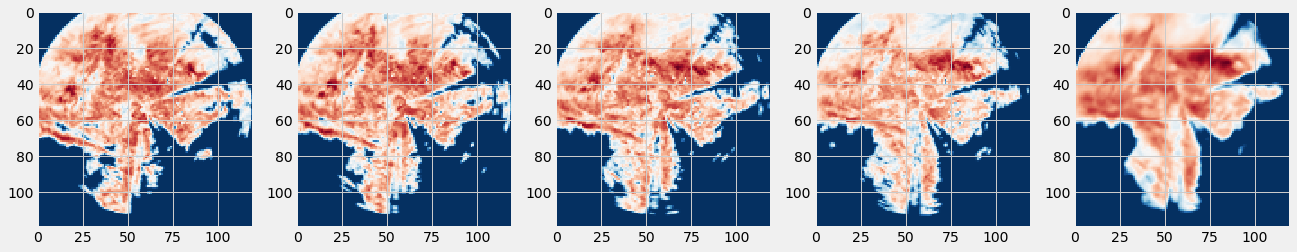

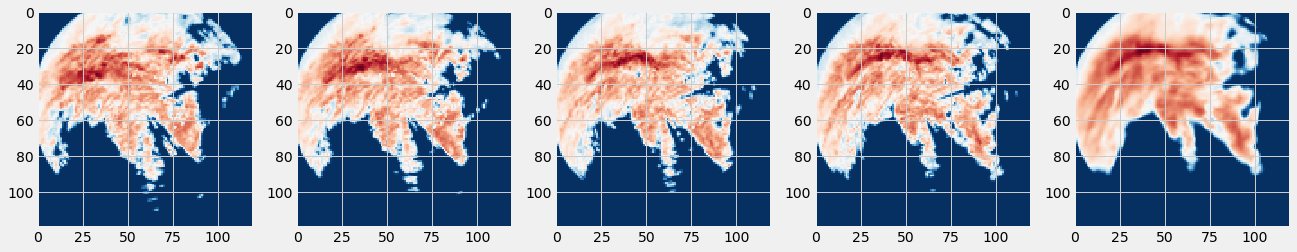

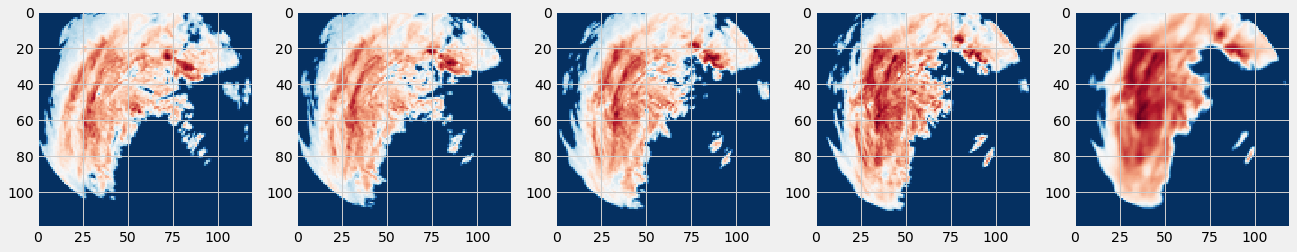

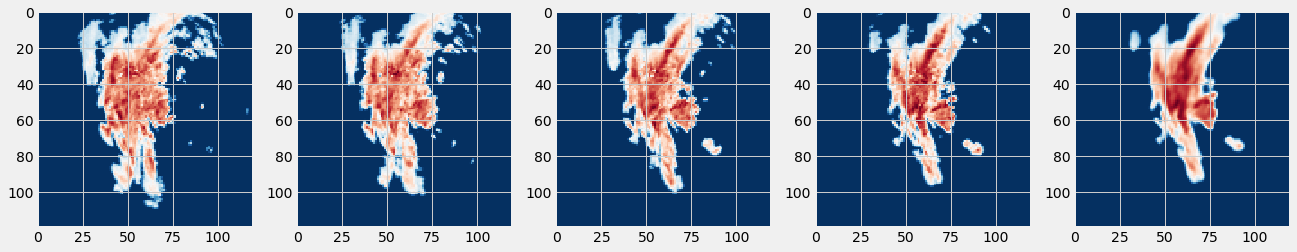

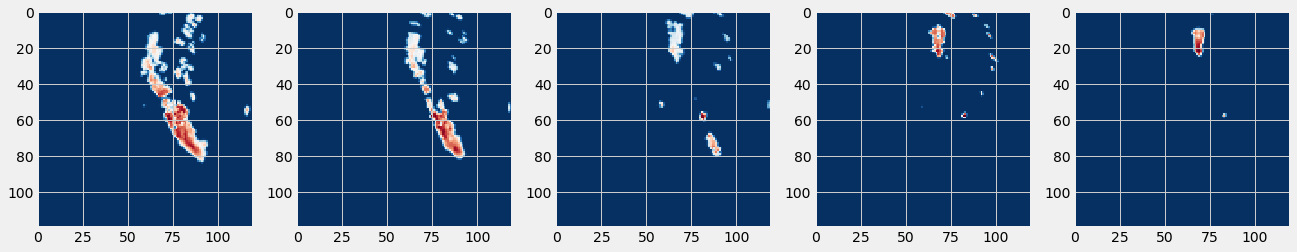

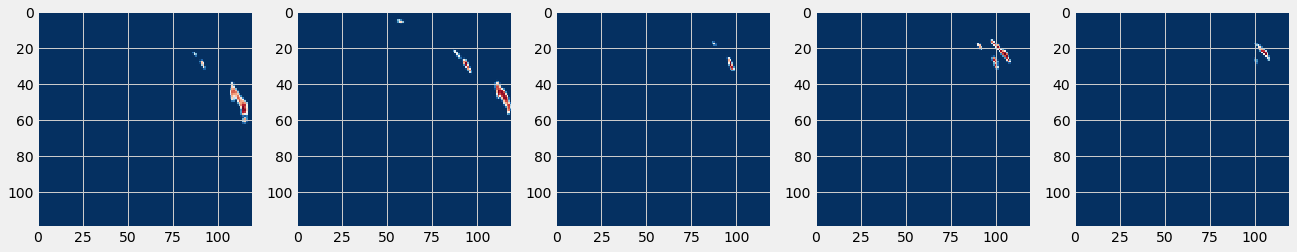

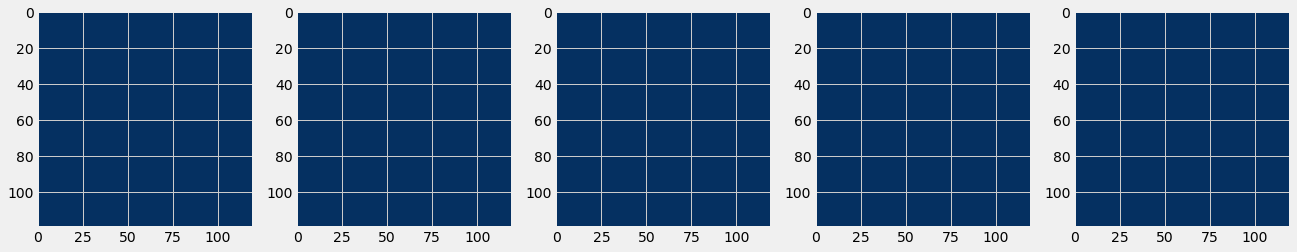

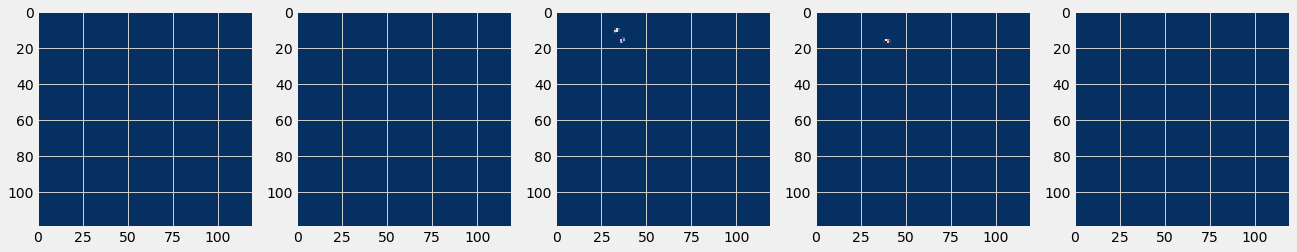

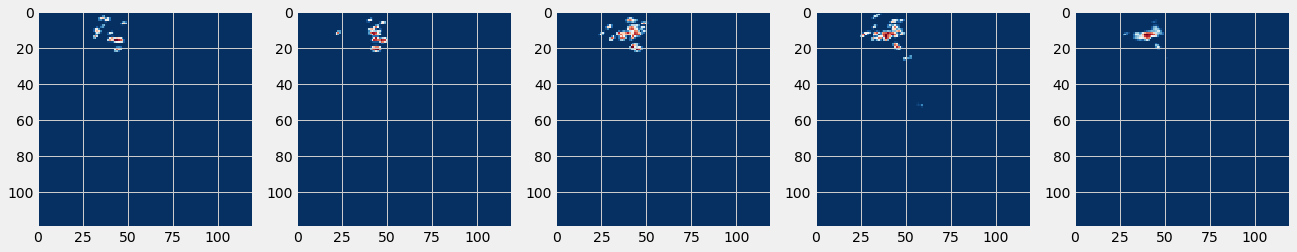

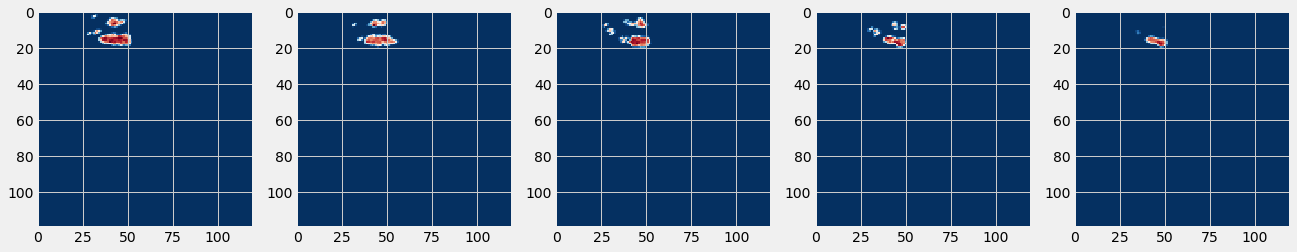

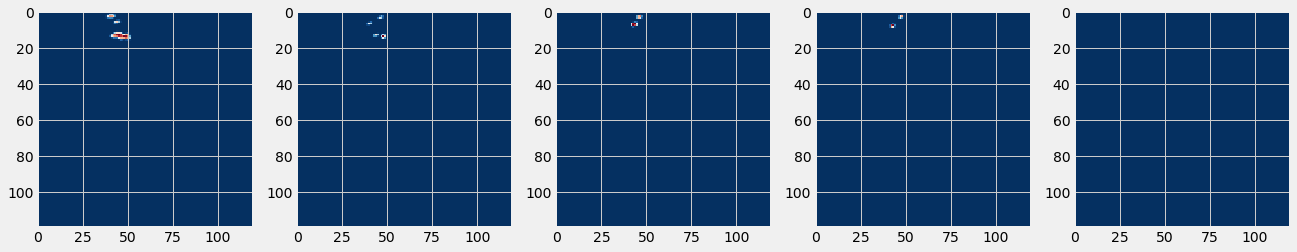

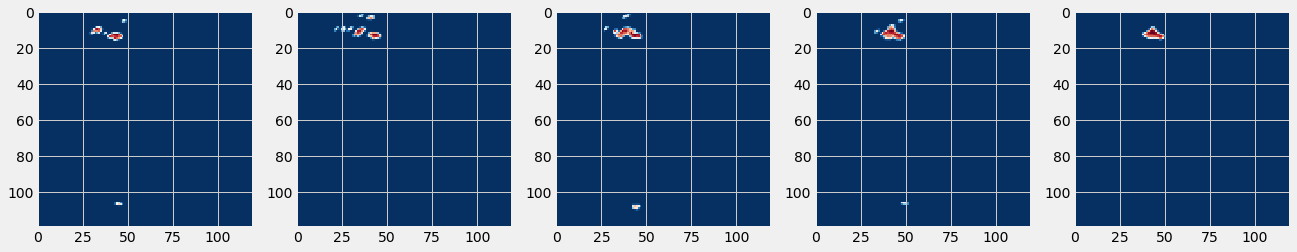

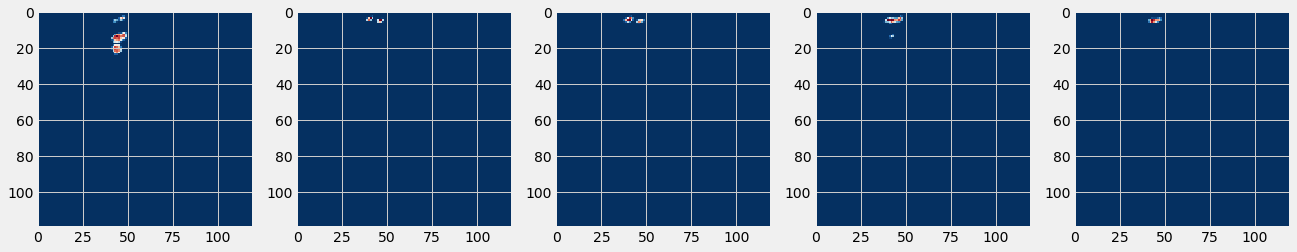

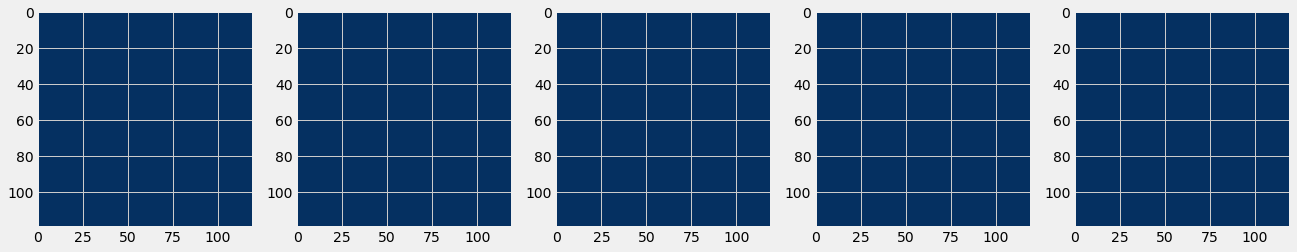

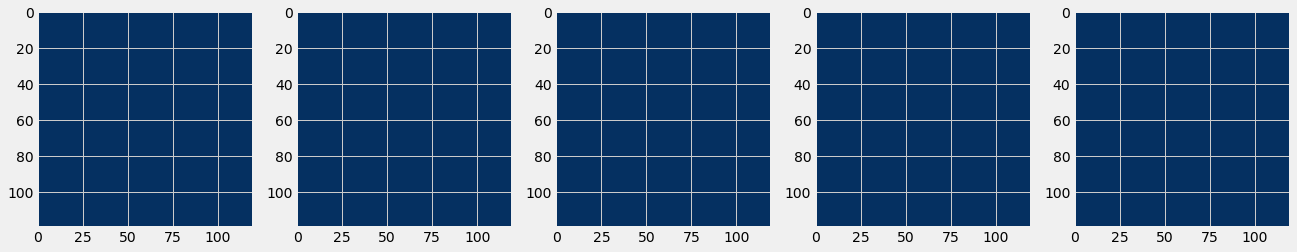

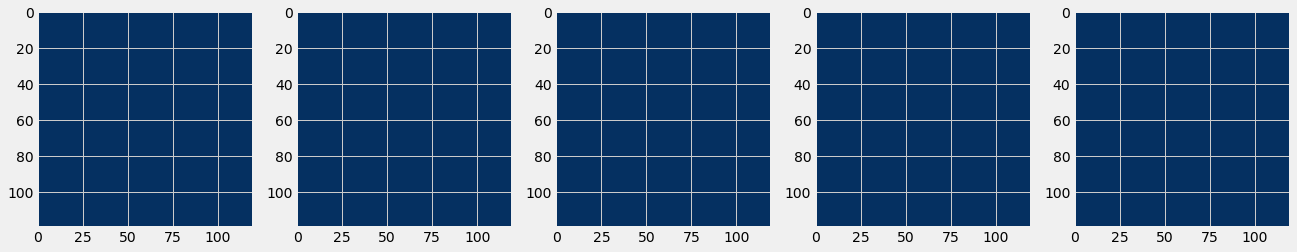

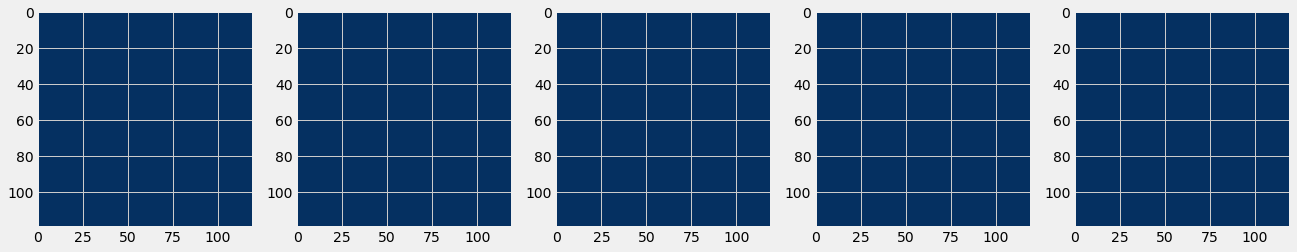

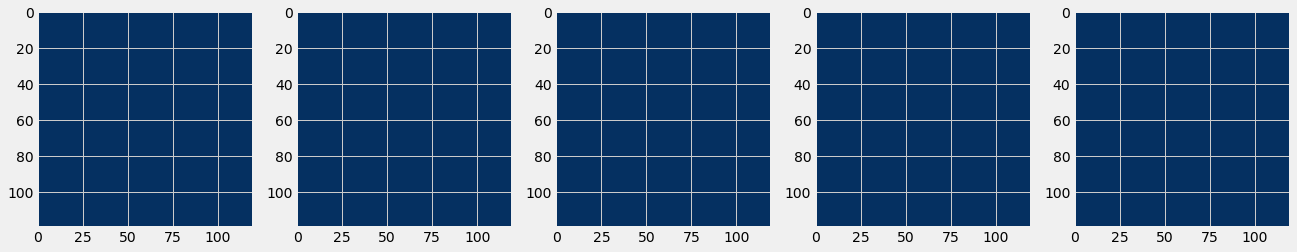

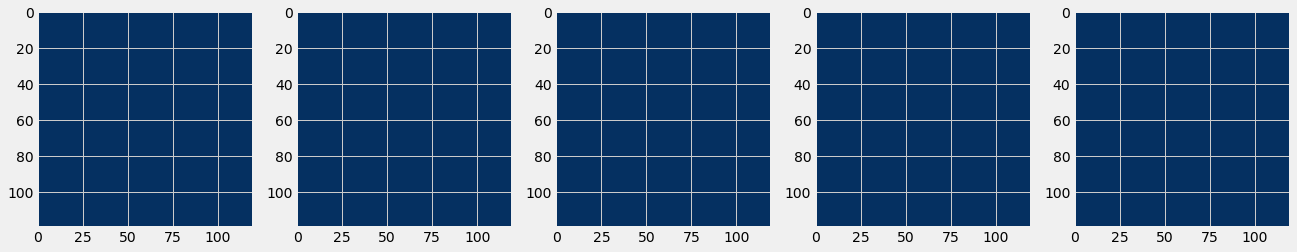

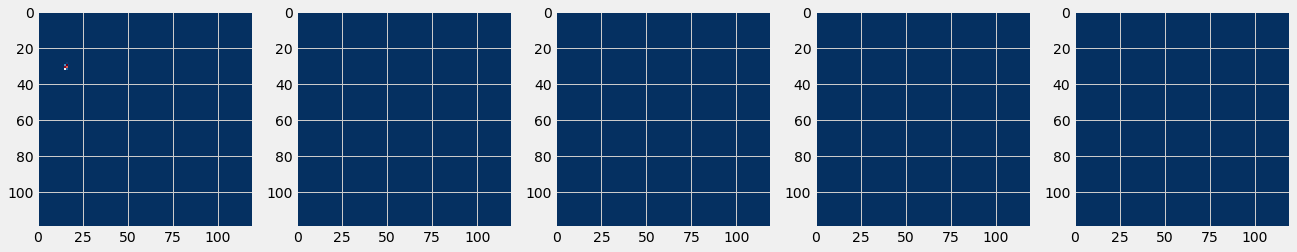

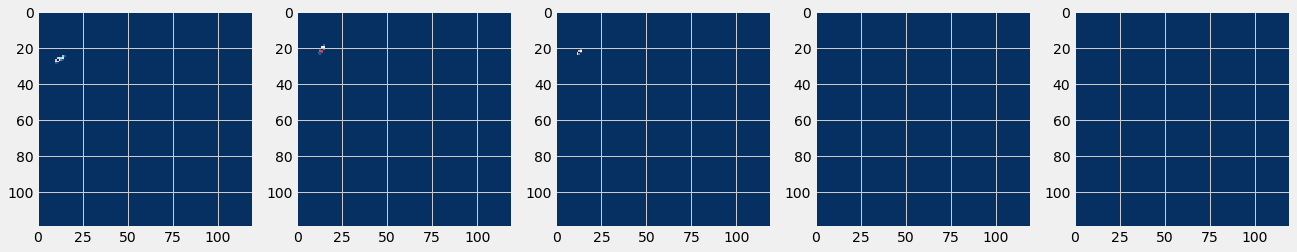

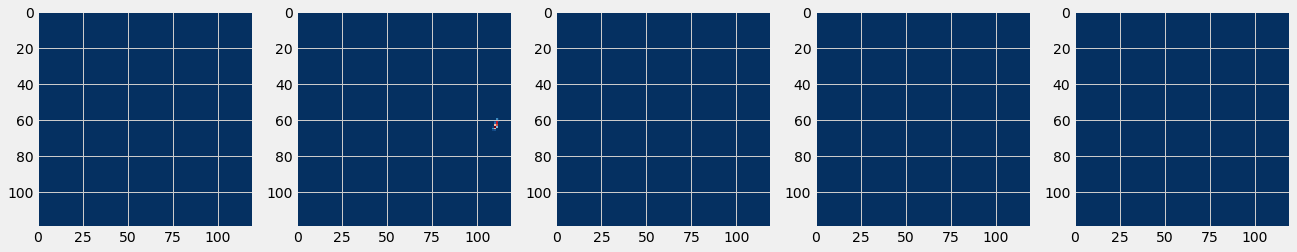

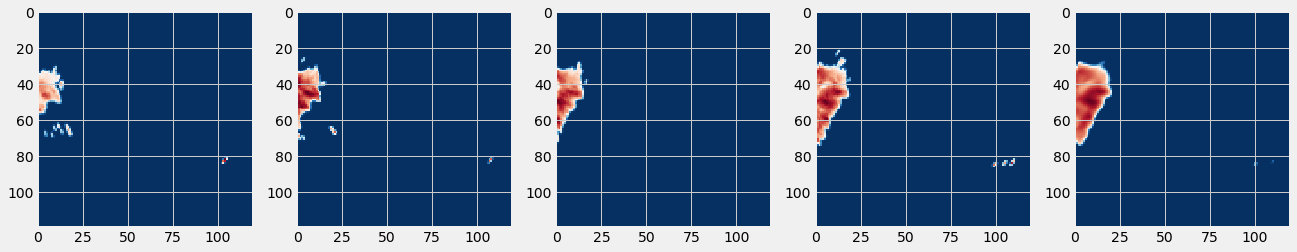

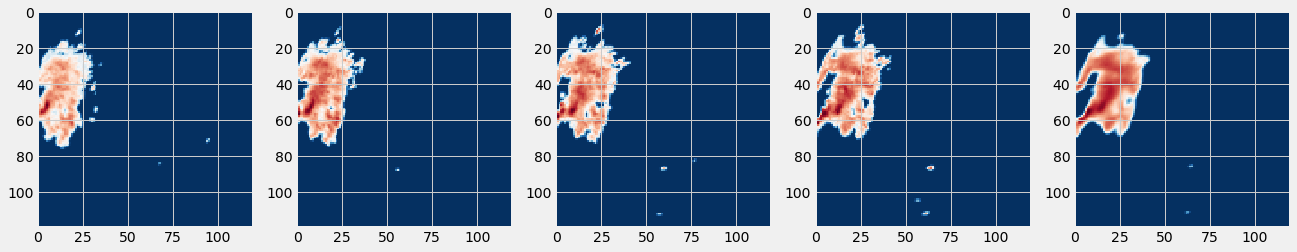

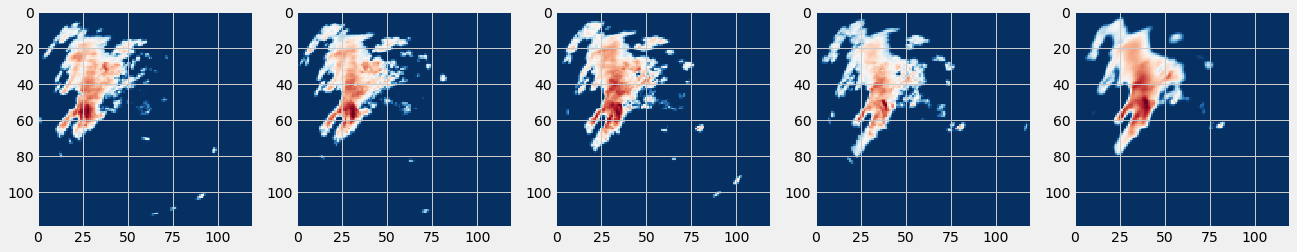

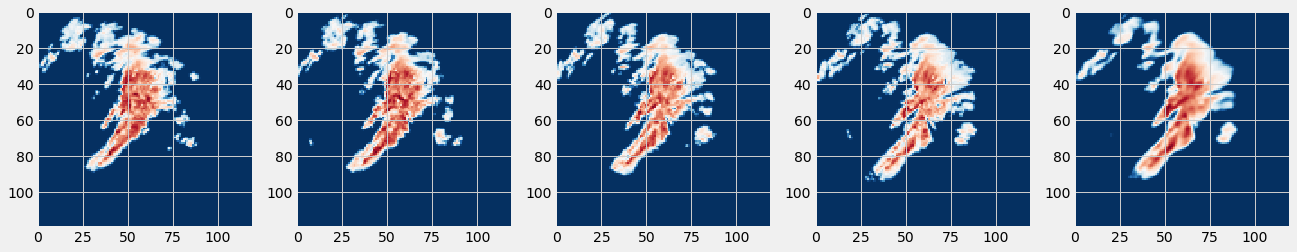

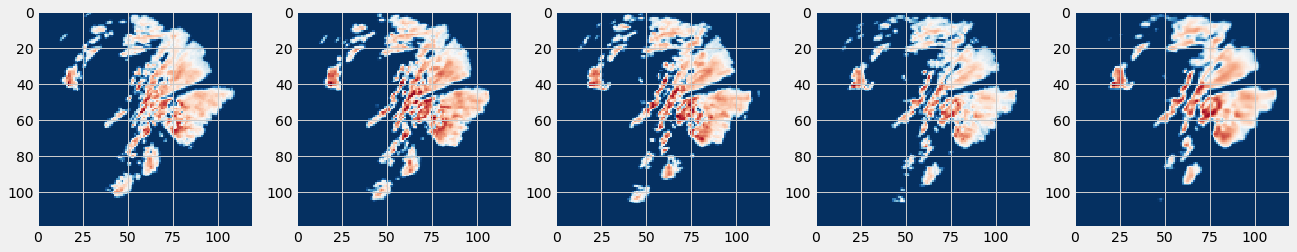

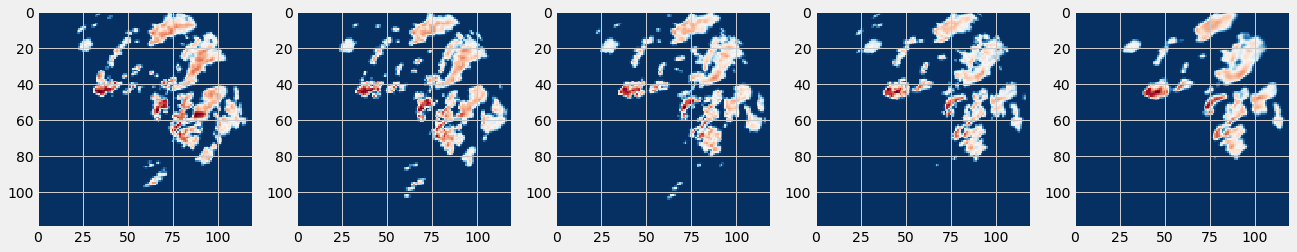

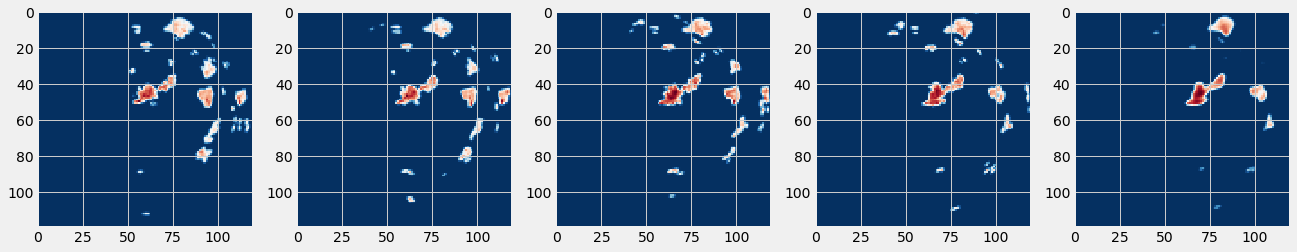

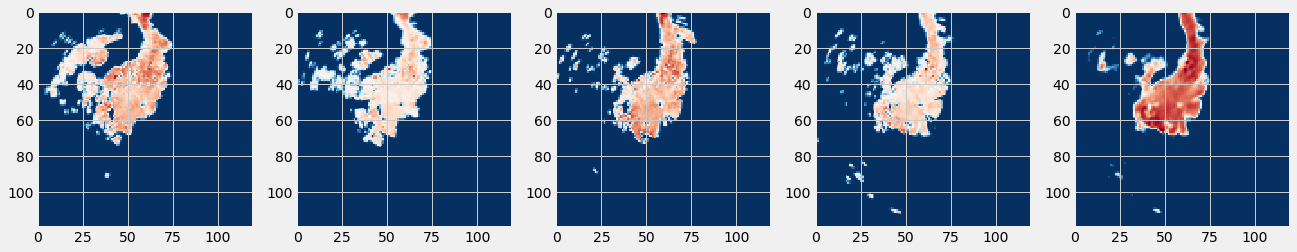

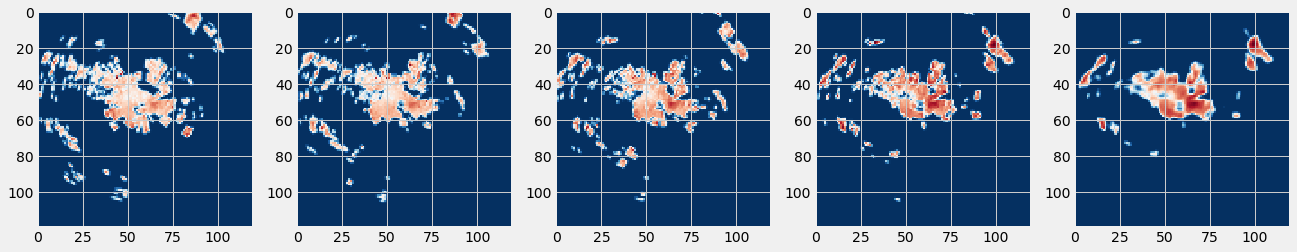

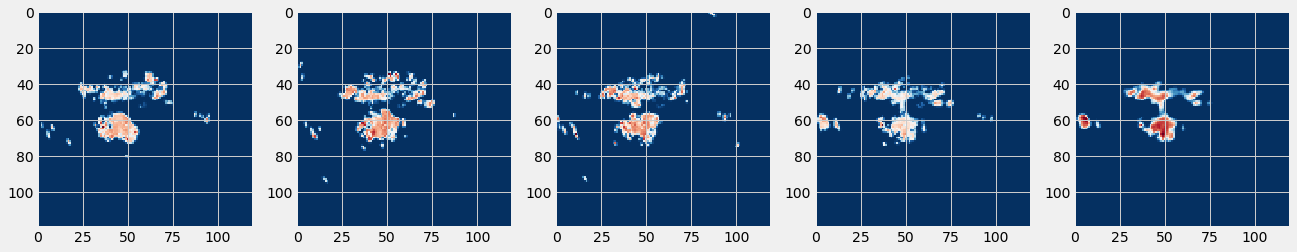

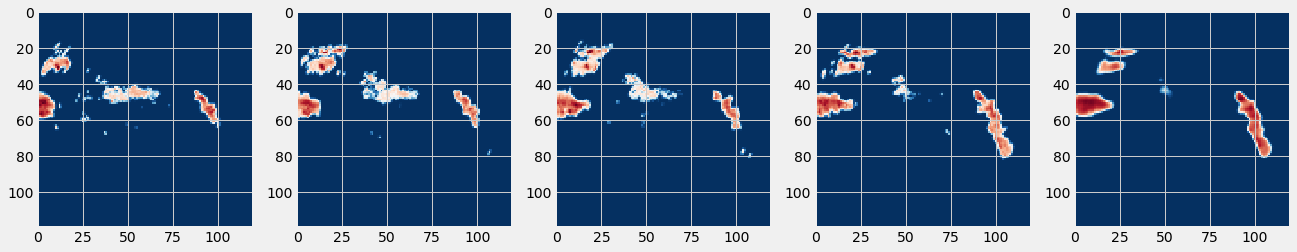

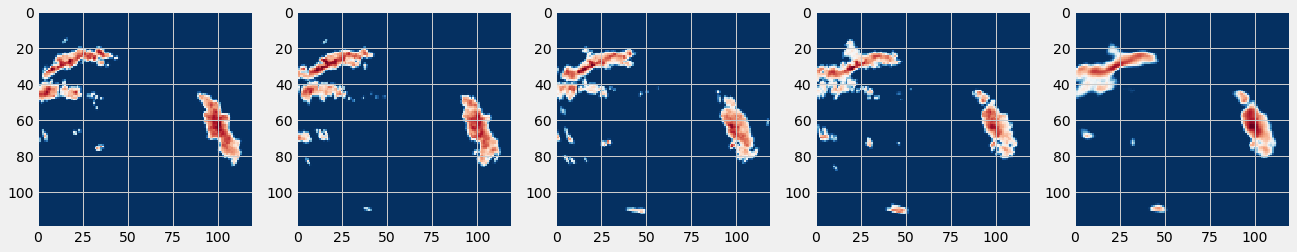

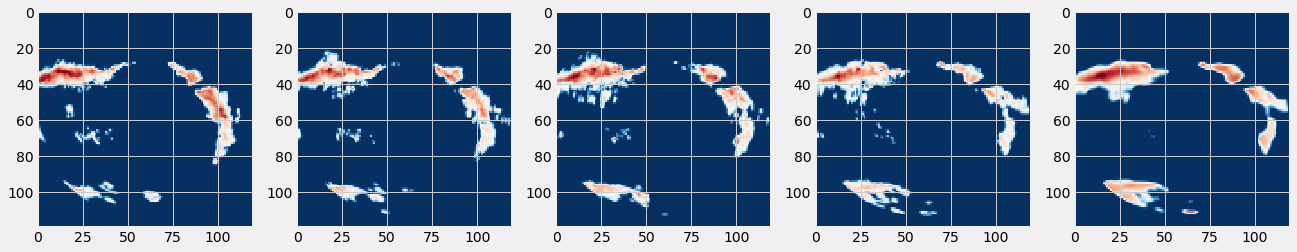

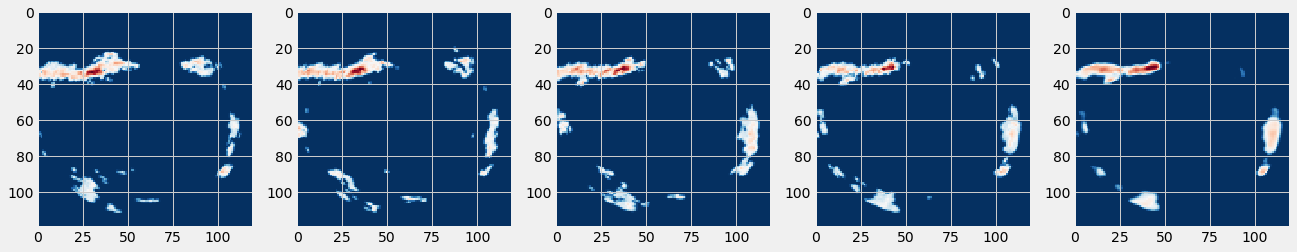

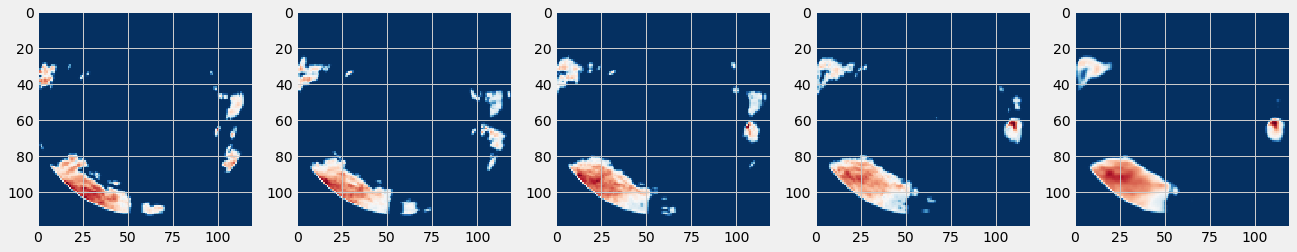

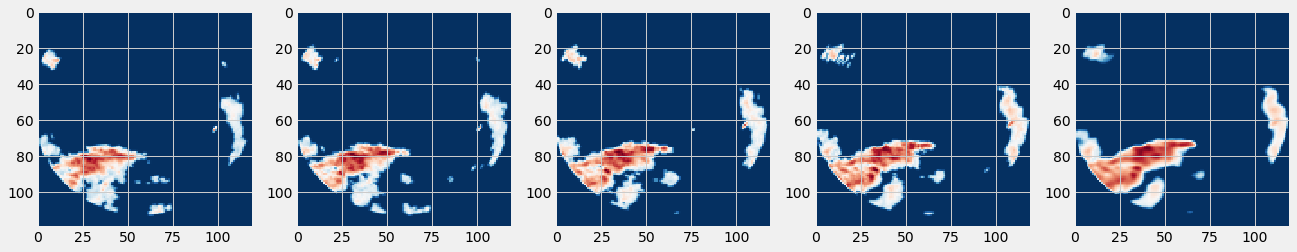

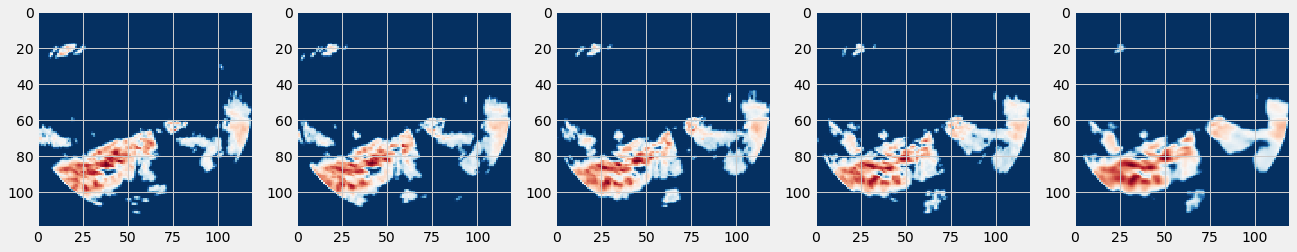

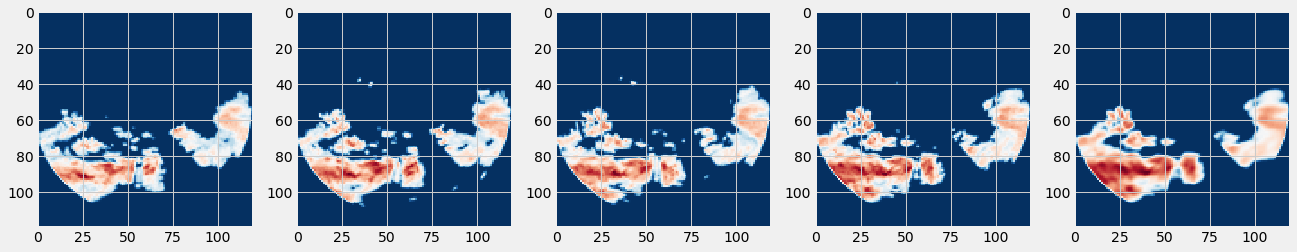

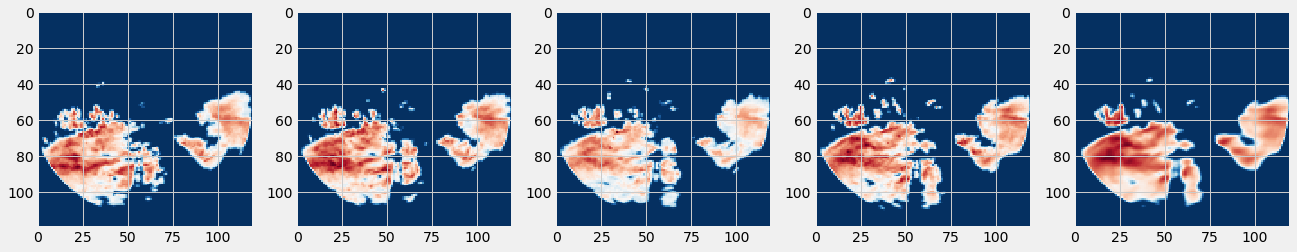

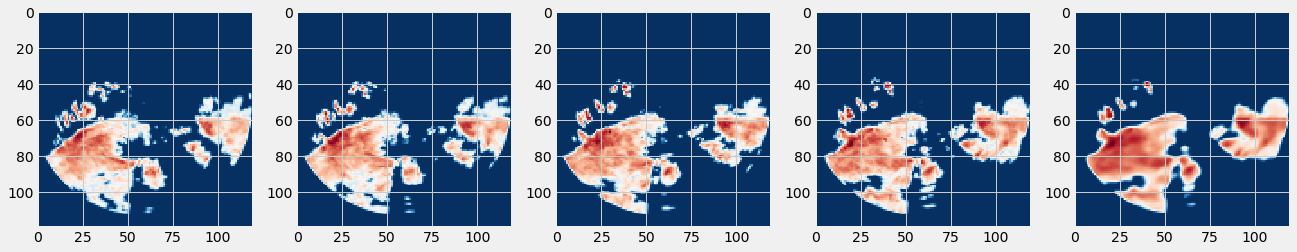

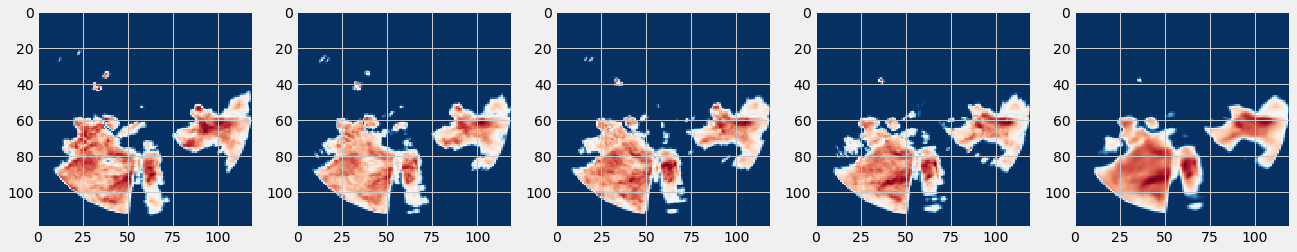

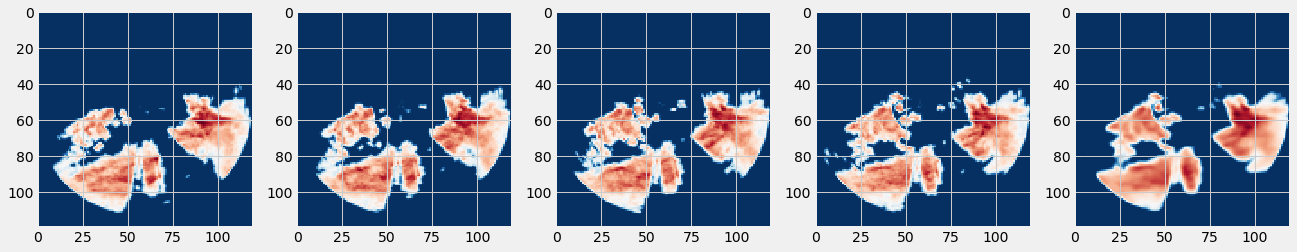

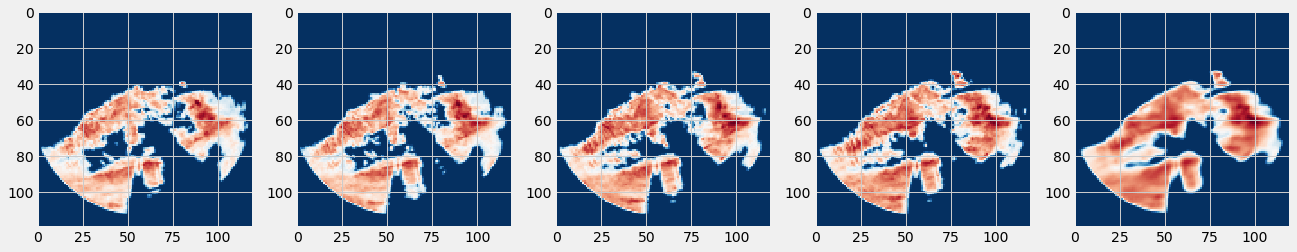

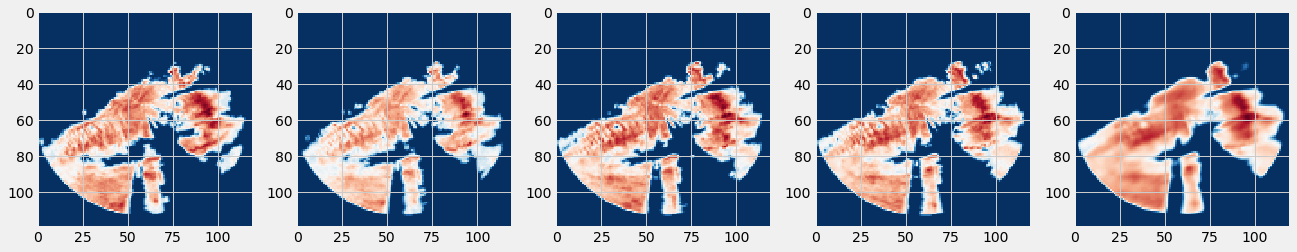

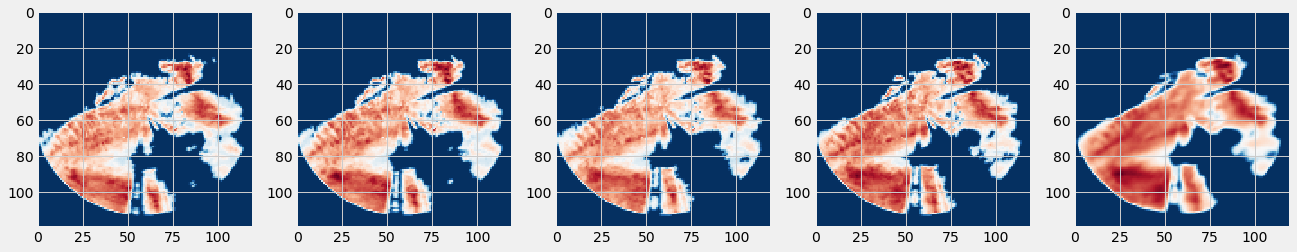

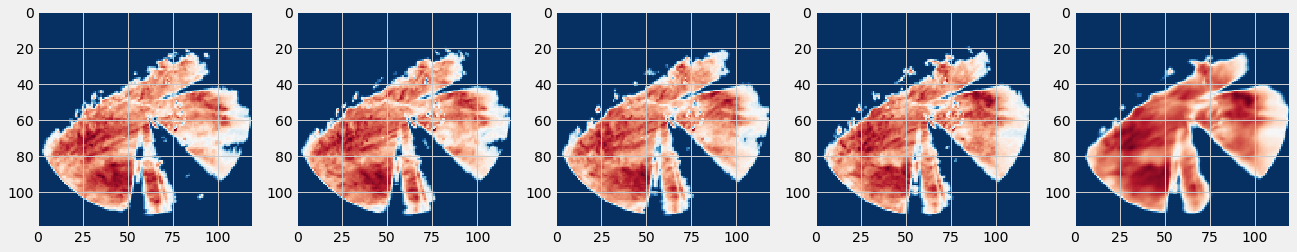

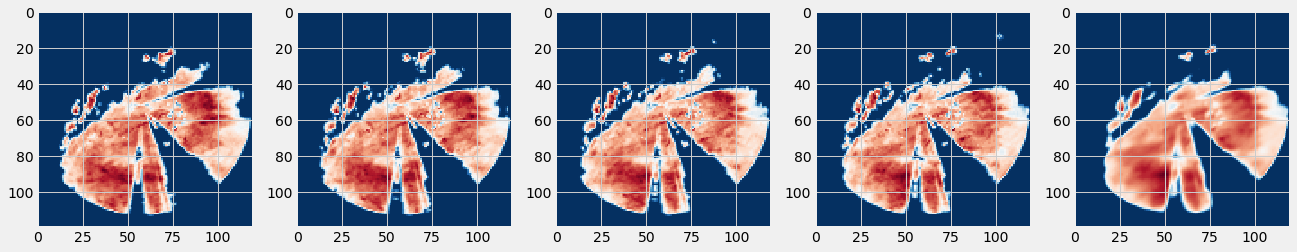

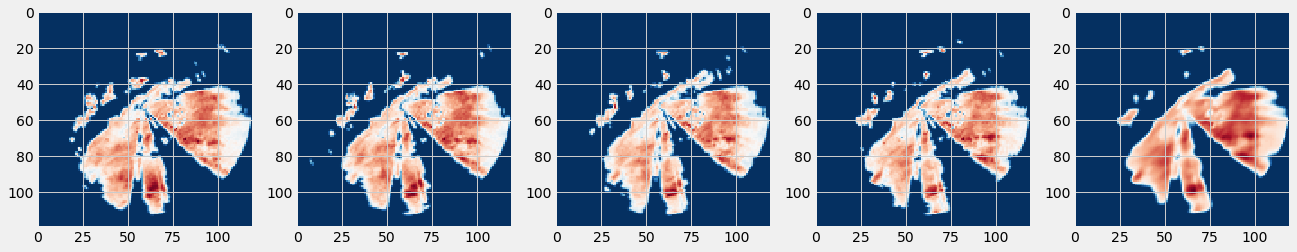

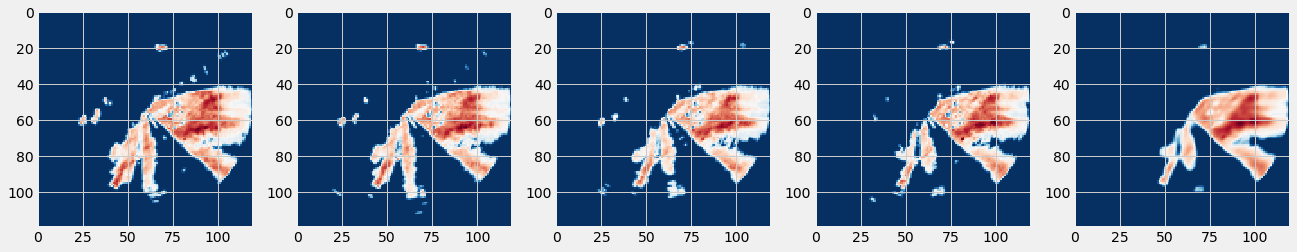

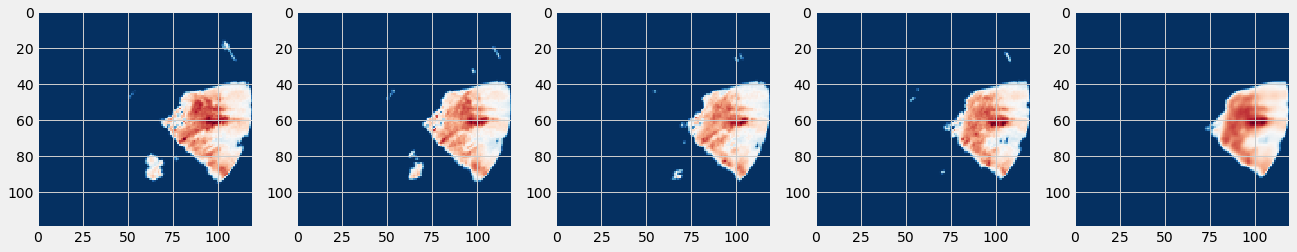

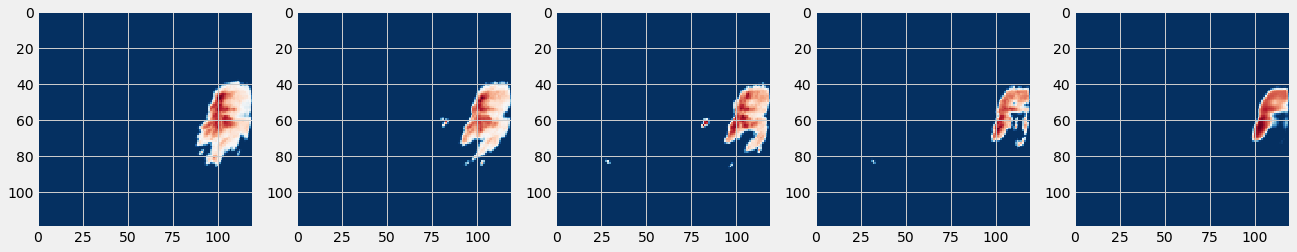

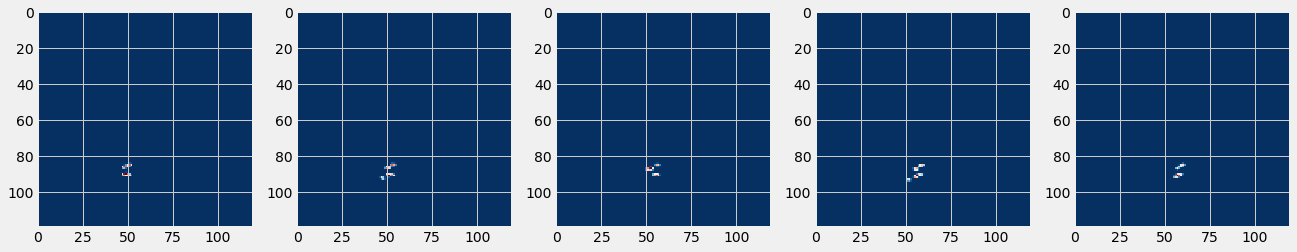

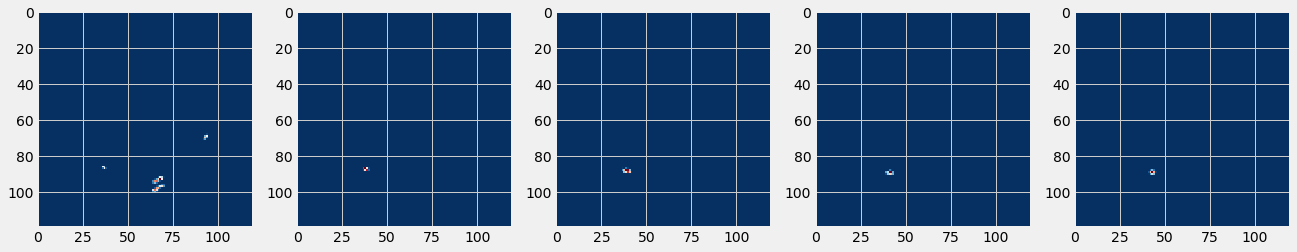

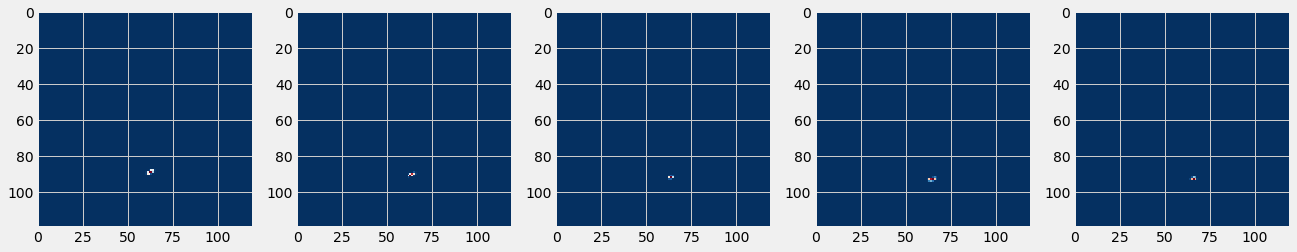

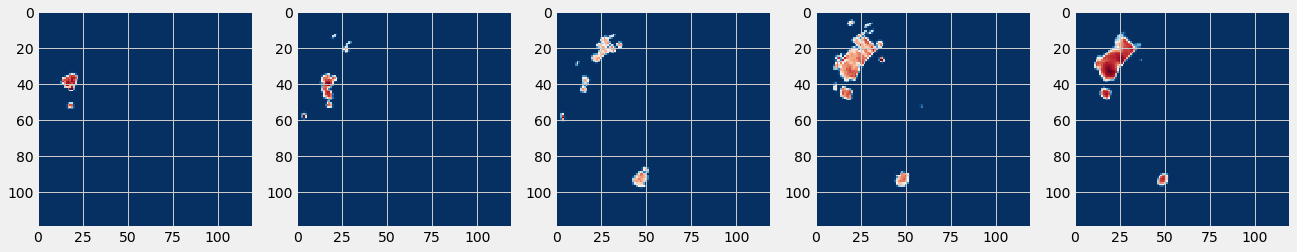

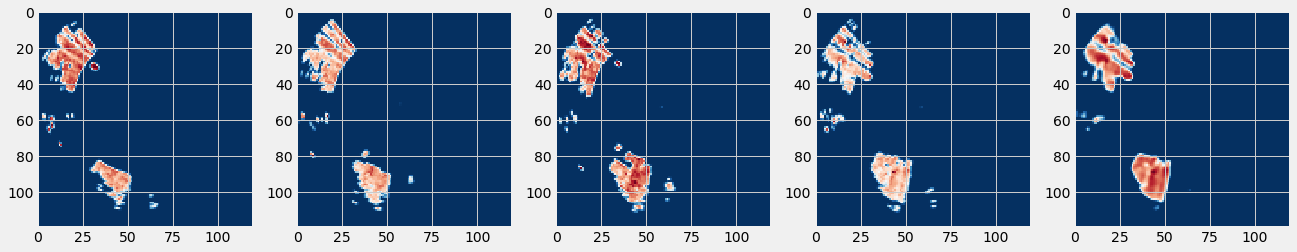

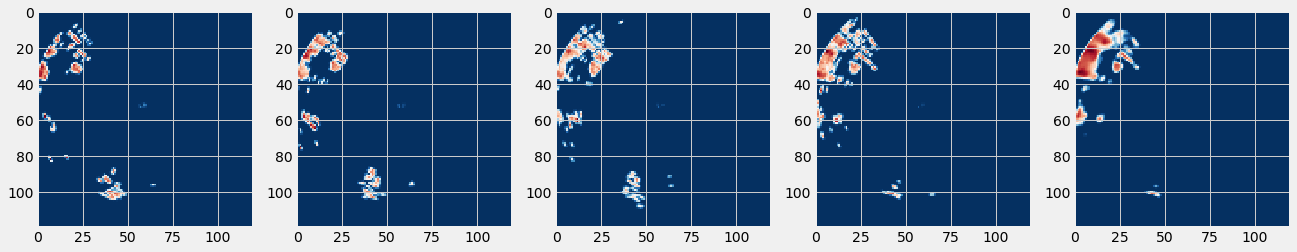

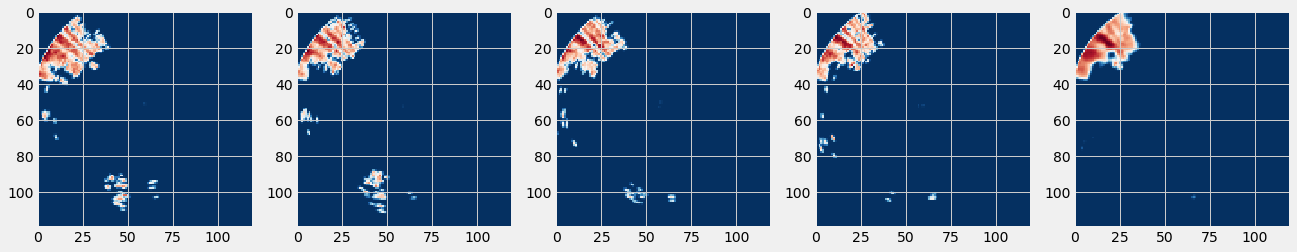

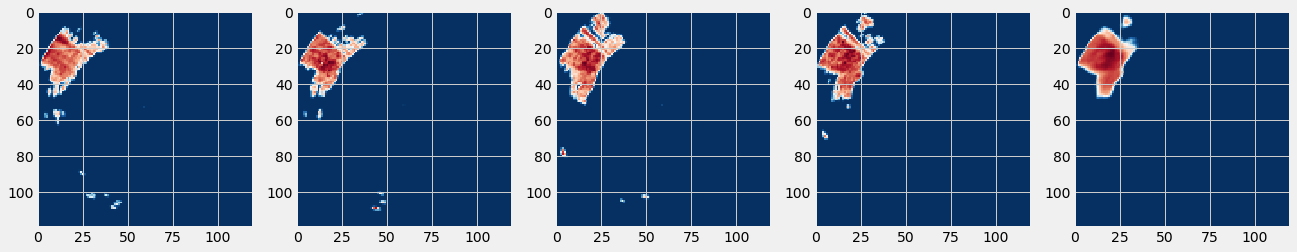

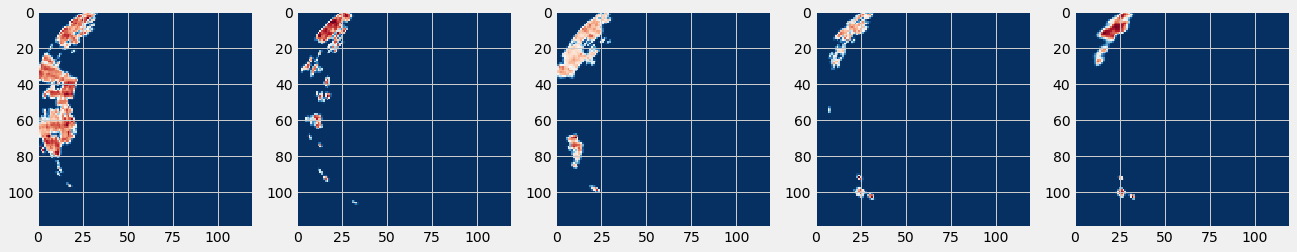

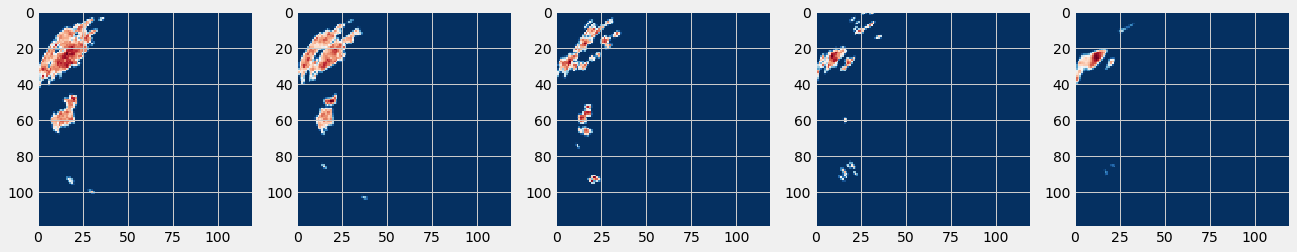

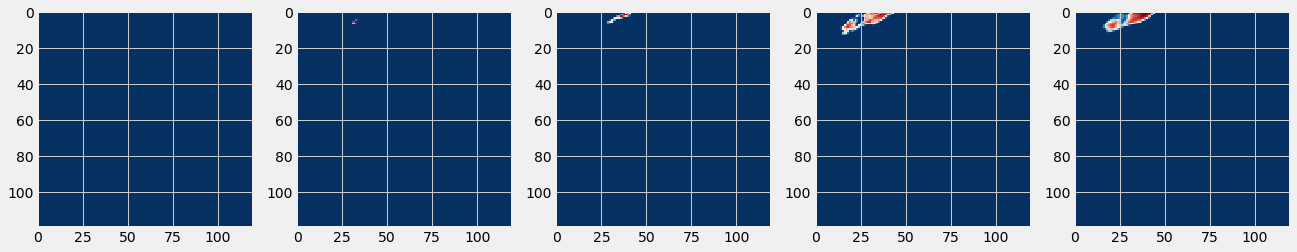

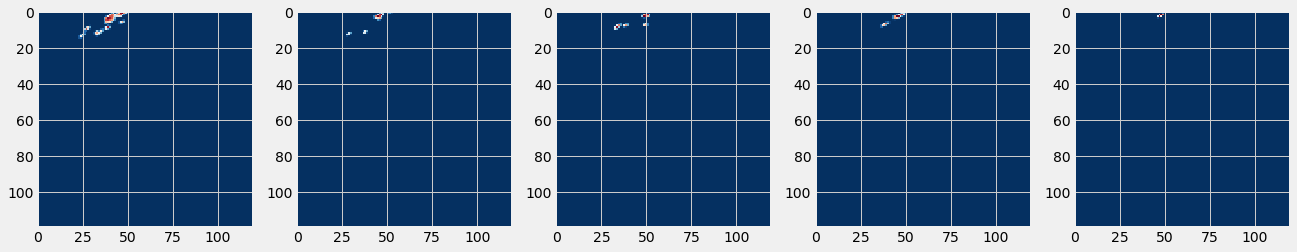

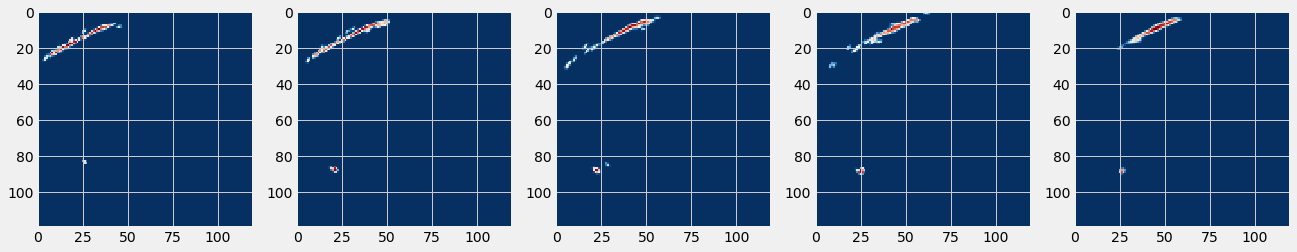

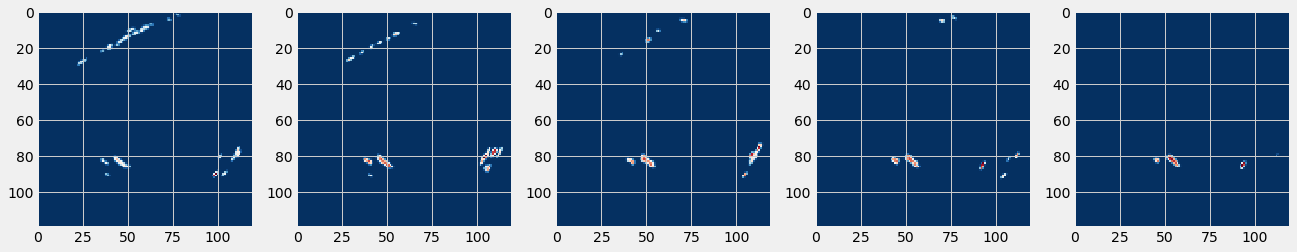

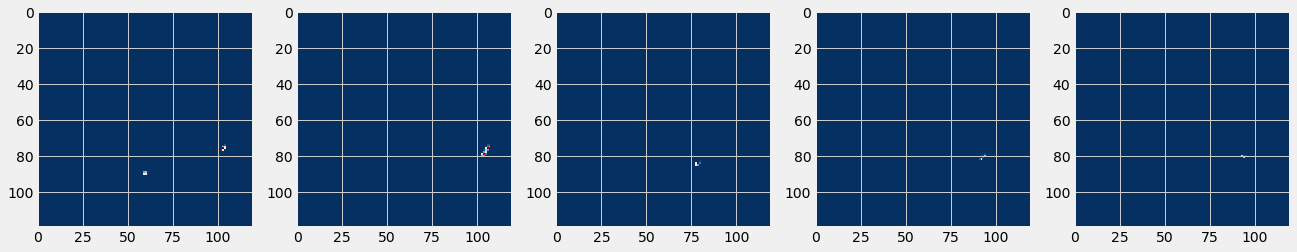

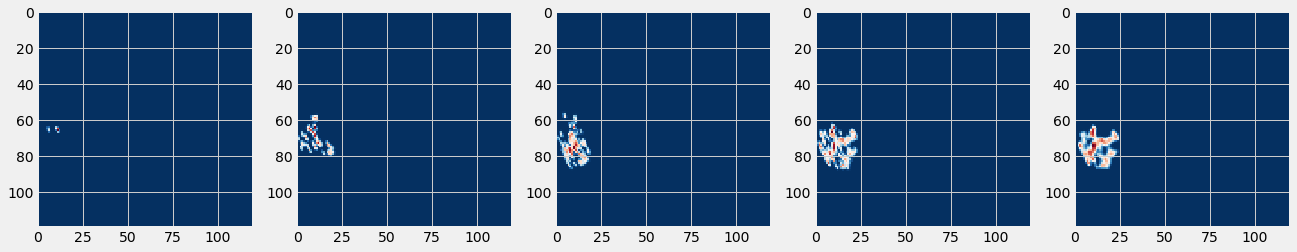

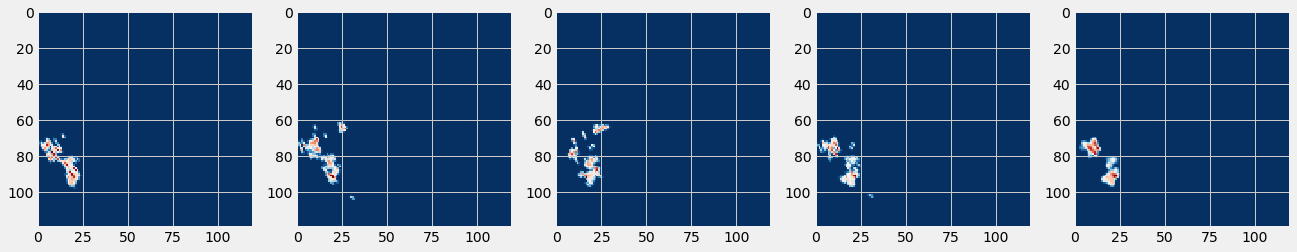

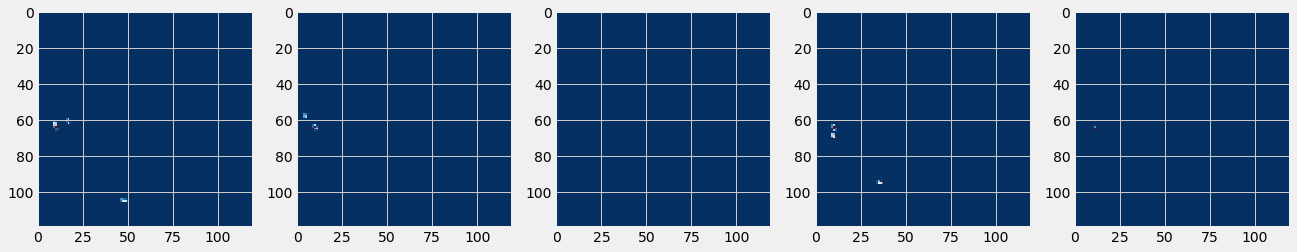

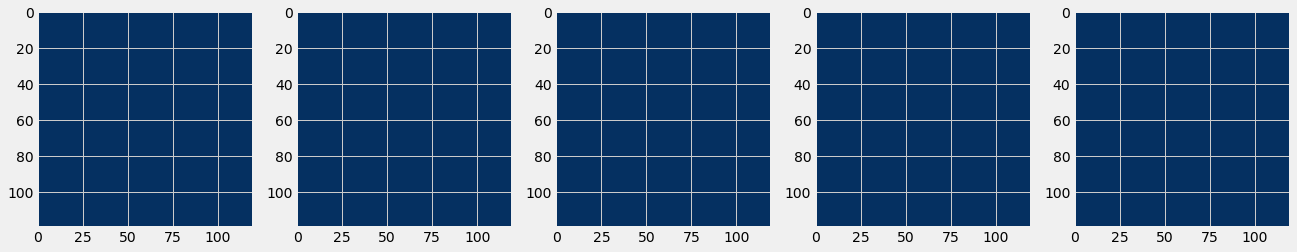

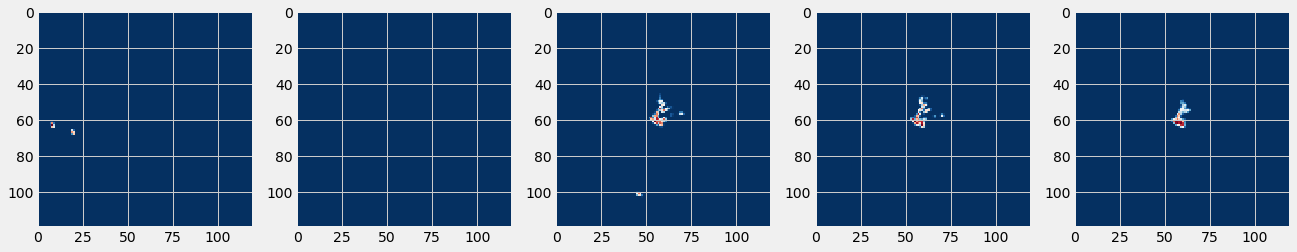

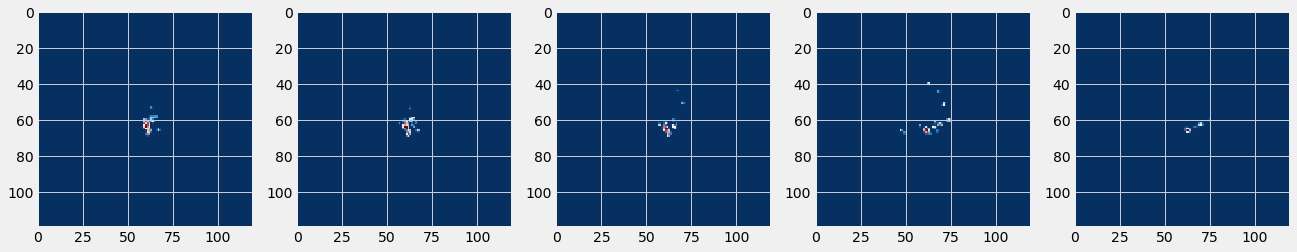

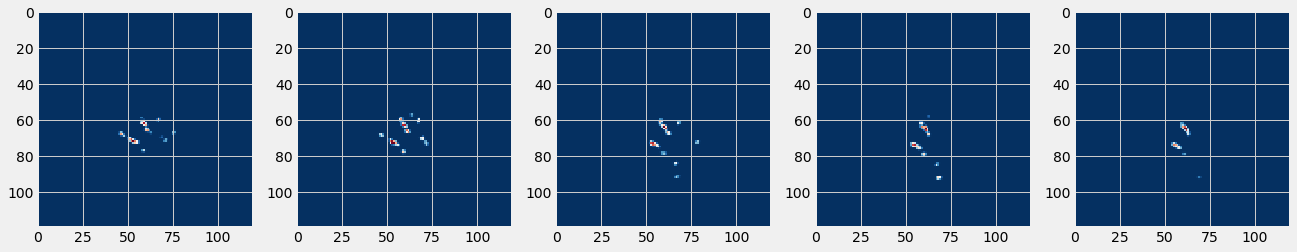

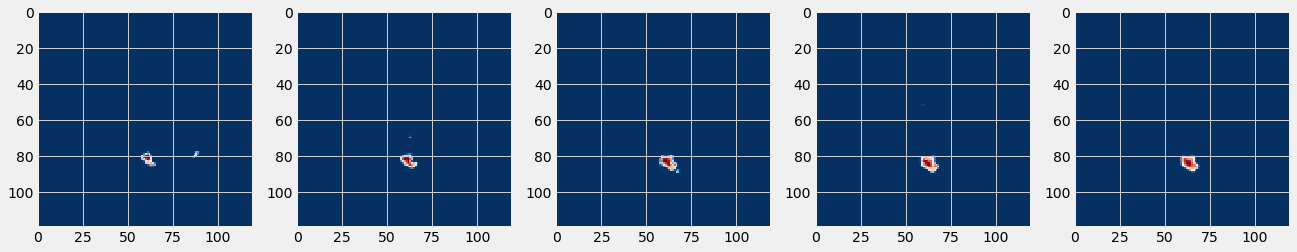

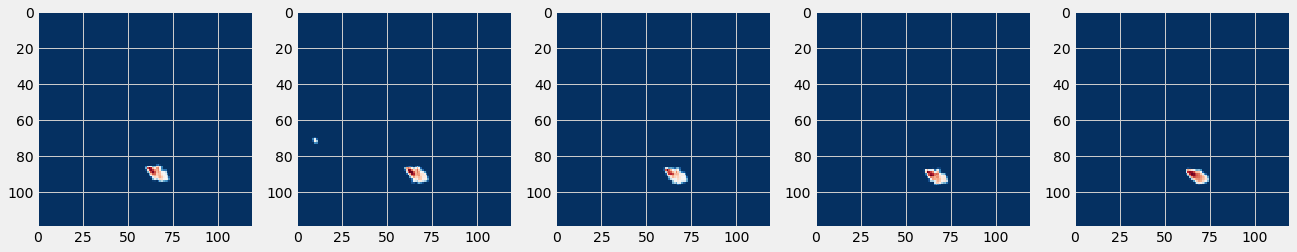

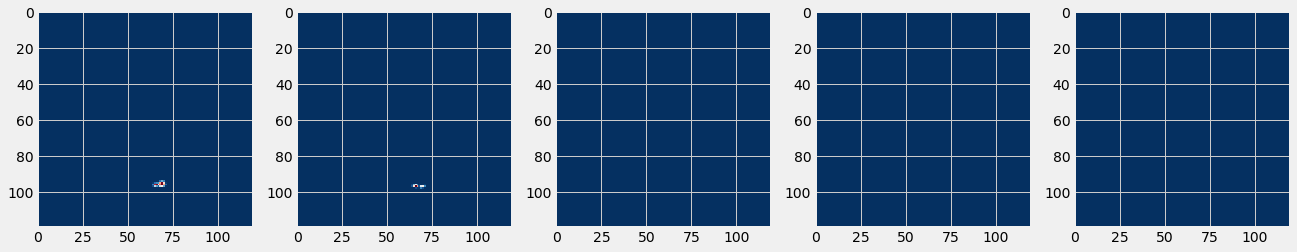

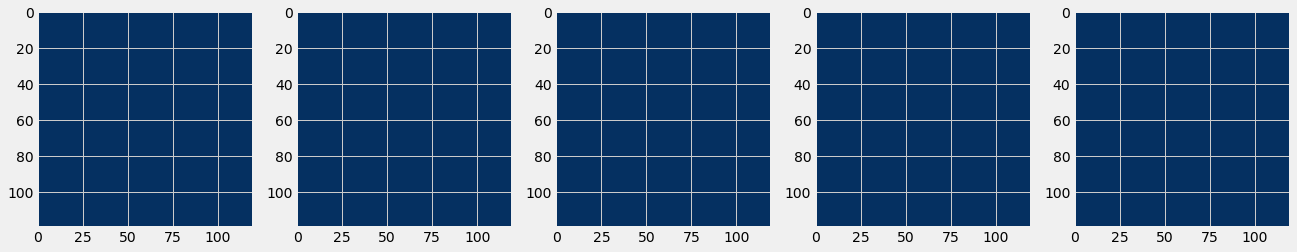

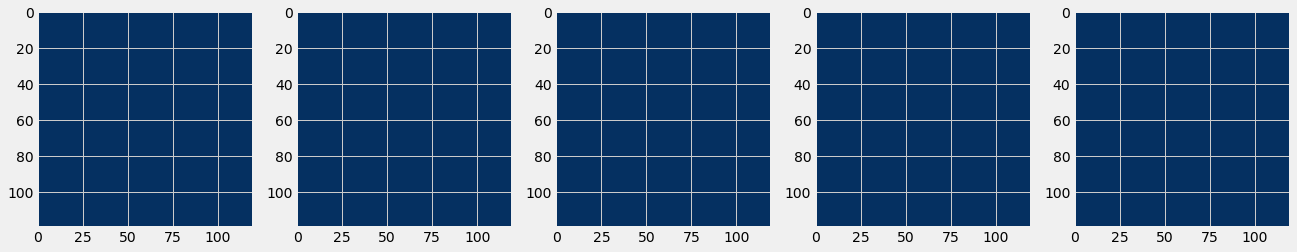

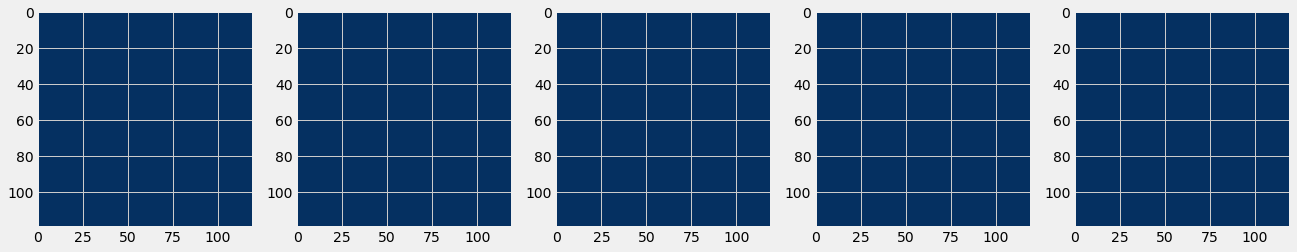

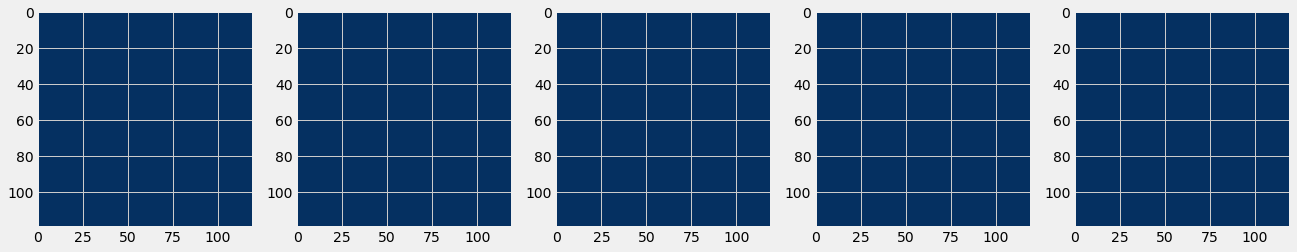

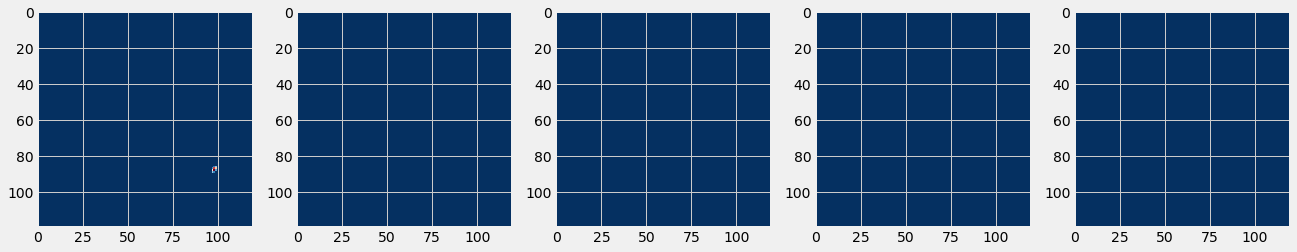

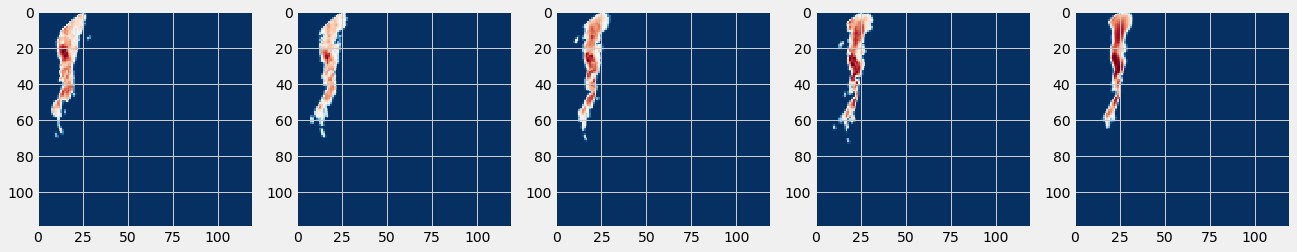

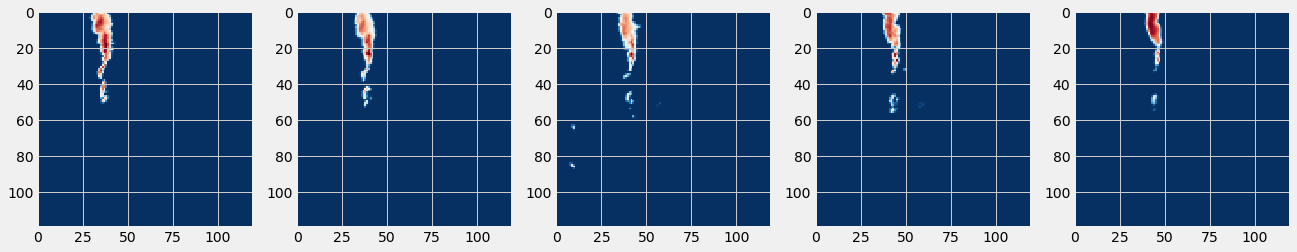

In [24]:
import matplotlib.pylab as plt
# (Submission 파일의 column index 값 : 6071, 6304, 7026, 7629, 7767, 8944, 11107)


color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

for img in range(200):
    image_sample = np.load(test_files[img]).flatten().reshape(120, 120, 4)

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20, 20))

    for i in range(4):
        plt.subplot(1,5,i+1)
        plt.imshow(image_sample[:, :, i], cmap=color_map)

    plt.subplot(1,5,5)
    plt.imshow(np.array(submission.iloc[img,1:].values.flatten().reshape(120, 120), dtype='uint8'), cmap = color_map)
    plt.show()